In [1]:
import numpy as np
import numpy.fft as fft
from astropy.io import fits
import matplotlib.pyplot as plt
import galsim

In [2]:
img1 = np.abs(fits.open('psf2asec-96.psf.fits')[0].data[0,0,:,:])
img2 = np.abs(fits.open('psf5asec-96.psf.fits')[0].data[0,0,:,:])
print(img1.shape)
print(img2.shape)

(96, 96)
(96, 96)


### PSF

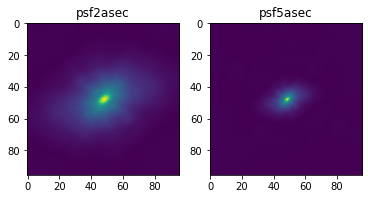

In [3]:
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('psf2asec')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('psf5asec')
plt.show()

### Centered FFT of PSF

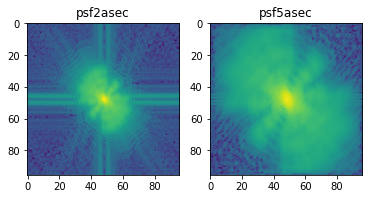

In [4]:
img1_fft = np.abs(fft.fftshift(fft.fft2(img1)))
img2_fft = np.abs(fft.fftshift(fft.fft2(img2)))

plt.subplot(1,2,1)
plt.imshow(np.log10(img1_fft))
plt.title('psf2asec')

plt.subplot(1,2,2)
plt.imshow(np.log10(img2_fft))
plt.title('psf5asec')
plt.show()

# Convolution of a Gaussian Galaxy & PSF using Galsim functions

In [5]:
gal_flux = 1.e5    # total counts on the image
gal_sigma = 2.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30.        # standard deviation of the counts in each pixel

In [6]:
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
psf = galsim.Gaussian(flux=1., sigma=2.)

gal, psf

(galsim.Gaussian(sigma=2.0, flux=100000.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)),
 galsim.Gaussian(sigma=2.0, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)))

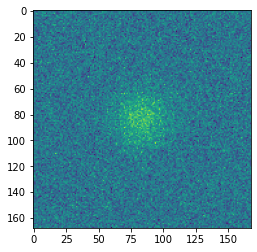

In [7]:
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

plt.imshow(image.array)
plt.show()

# Convolution of the given PSF with a Gaussian Galsim Object (multiplication in Fourier Space)

In [8]:
gal_1 = np.abs(galsim.Gaussian(flux=gal_flux, sigma=gal_sigma).drawImage(nx=96, ny=96).array)
psf_img1 = galsim.Image(img1, copy=True).array

psf_img1 /= np.sum(psf_img1)

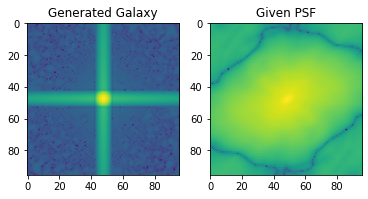

Dimensions - (96, 96) (96, 96)


In [9]:
plt.subplot(1,2,1)
plt.imshow(np.log10(gal_1))
plt.title('Generated Galaxy')

plt.subplot(1,2,2)
plt.imshow(np.log10(psf_img1))
plt.title('Given PSF')
plt.show()

m = gal_1.shape
n = psf_img1.shape
print('Dimensions -', m,n) 

### FFT

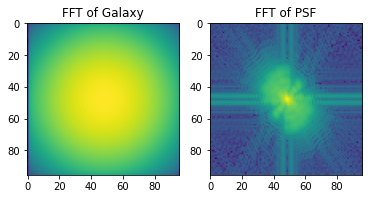

Dimensions - (96, 96) (96, 96)


In [10]:
gal_1_fft = np.pad(np.abs(fft.fftshift(fft.fft2(gal_1))), (abs(m[0]-n[0])//2, abs(m[1]-n[1])//2 ), 'constant')     
psf_img1_fft = np.abs(fft.fftshift(fft.fft2(psf_img1)))        

plt.subplot(1,2,1)
plt.imshow(np.log10(gal_1_fft))
plt.title('FFT of Galaxy')

plt.subplot(1,2,2)
plt.imshow(np.log10(psf_img1_fft))
plt.title('FFT of PSF')
plt.show()

print('Dimensions -', gal_1_fft.shape, psf_img1_fft.shape)

### Add Gaussian Noise to FFT(Galaxy)

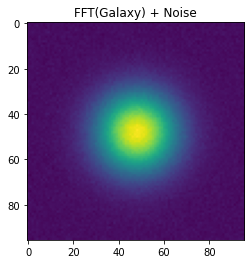

In [11]:
gal_1_fft_GSO = galsim.Image(gal_1_fft, copy=True)                  # Stored as GSO
gal_1_fft_GSO.addNoise(galsim.GaussianNoise(sigma=1e3)) 

plt.imshow(gal_1_fft_GSO.array)
plt.title('FFT(Galaxy) + Noise')
plt.show()

### Convolve with PSF

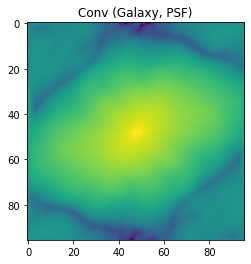

In [12]:
conv1 = np.multiply(gal_1_fft_GSO.array, psf_img1_fft)

final_gal = np.abs(fft.ifftshift(fft.ifft2(conv1)))   # IFFT to get back to brightness domain

plt.imshow(np.log10(final_gal))
plt.title('Conv (Galaxy, PSF)')
plt.show()

# Gradient Descent

In [13]:
iters = 5000

# Original Implementation - https://waller-lab.github.io/DiffuserCam/tutorial/GD.html

def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = fft.fft2(fft.ifftshift(hpad), norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

In [14]:
def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    return np.real(calcAHerm(Hadj, diff, pad))

In [15]:
def calcA(H, vk, crop):
    Vk = fft.fft2(fft.ifftshift(vk))
    return crop(fft.fftshift(fft.ifft2(H*Vk)))

In [16]:
def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(fft.ifftshift(xpad))
    return fft.fftshift(fft.ifft2(Hadj*X))

In [17]:
def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
    
    mse = np.zeros((iters))
        
    alpha = np.real(1.8/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi
    
    #proj = lambda x:x  # Do no projection
    proj = non_neg      # Enforce nonnegativity at every gradient step


    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v     
    
    # FISTA update parameters
    tk = 1
    xk = v
    
        
    for iterations in range(iters):     
        
        # FISTA update
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)

        image = proj(crop(vk))
        mse[iterations] = np.mean(np.abs(image - gal_1))
        
        if iterations % 10 == 0:
            f = plt.figure(1)
            plt.imshow(image)
            plt.title('Reconstruction after iteration {}'.format(iterations))
            plt.show(f)   
            #print(image)
            
        
    return proj(crop(vk)), mse

In [18]:
def gd_update(vk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    vk = proj(vk)
    
    return vk    

### FISTA Update

In [19]:
def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk

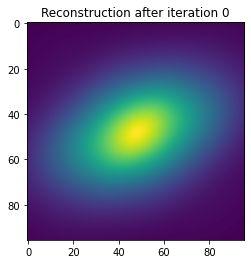

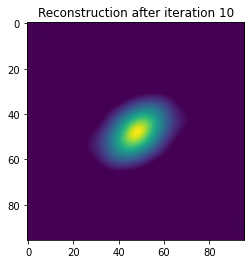

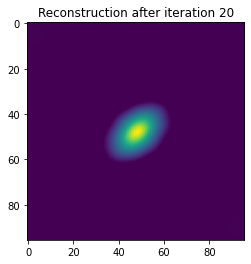

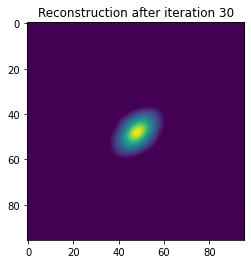

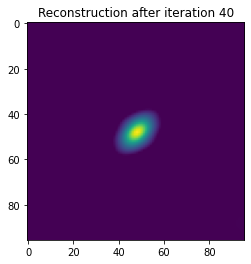

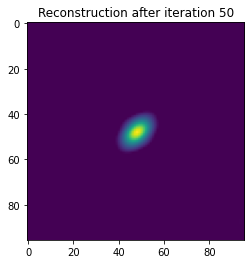

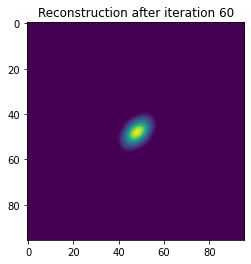

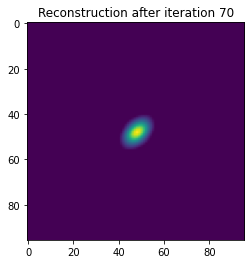

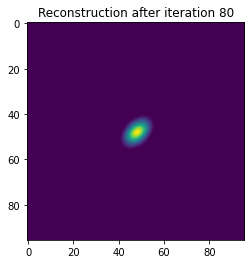

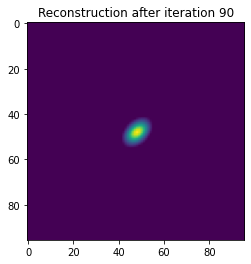

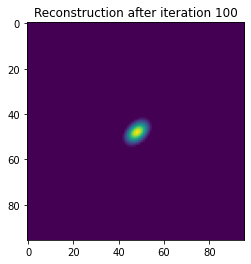

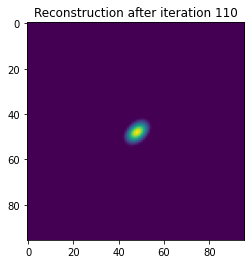

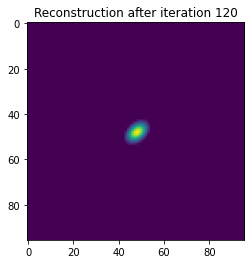

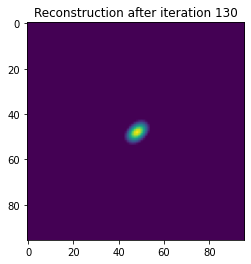

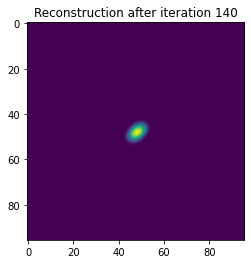

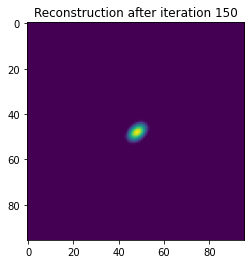

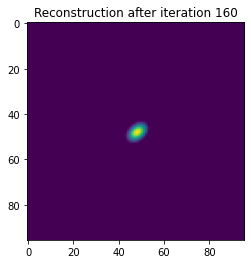

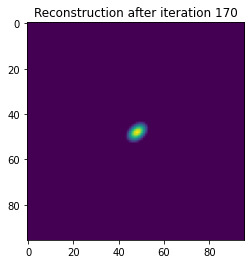

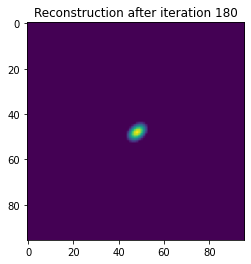

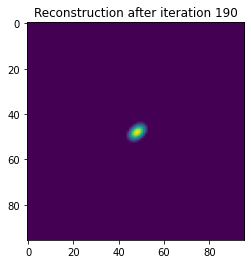

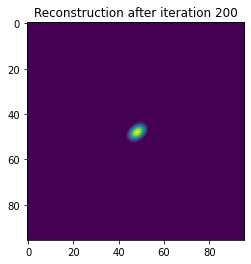

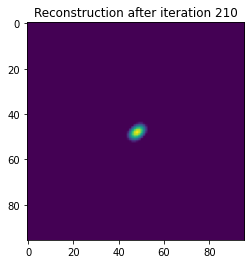

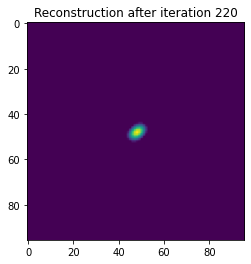

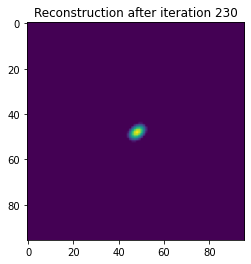

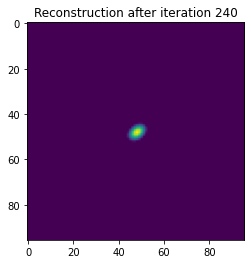

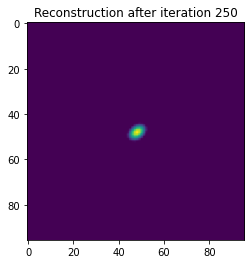

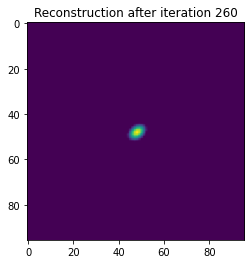

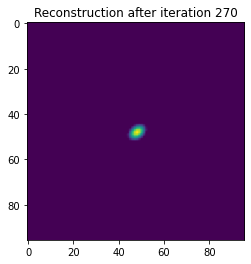

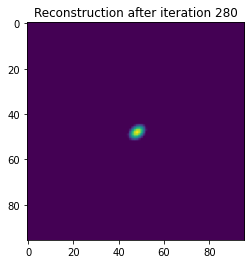

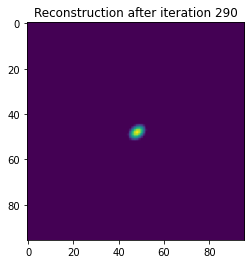

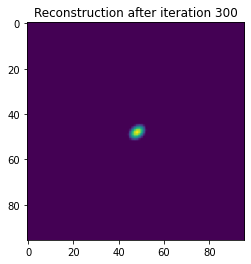

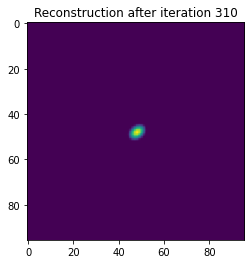

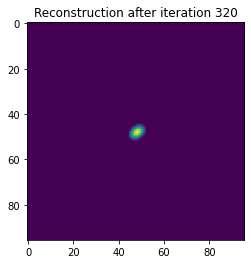

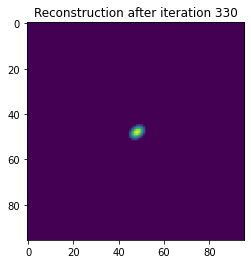

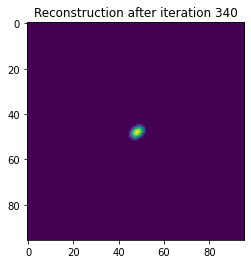

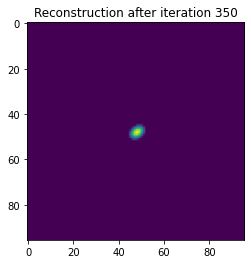

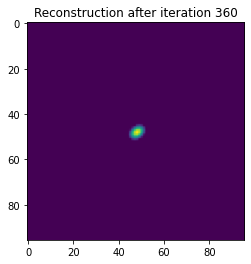

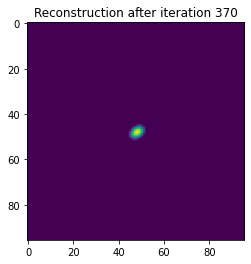

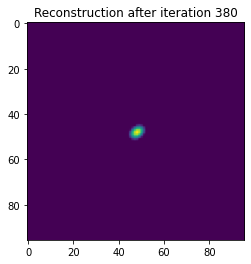

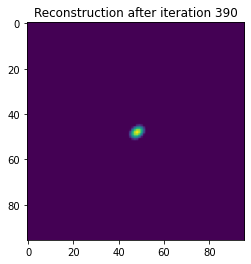

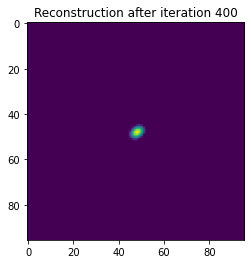

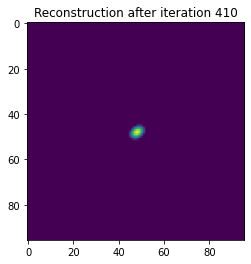

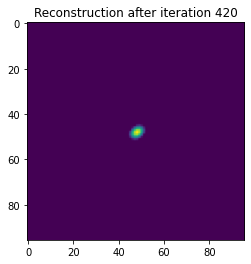

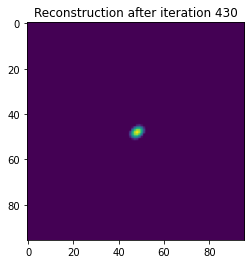

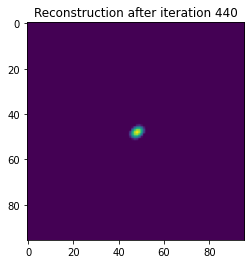

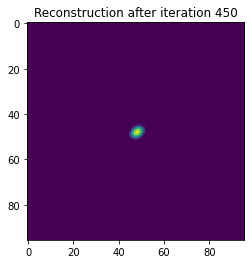

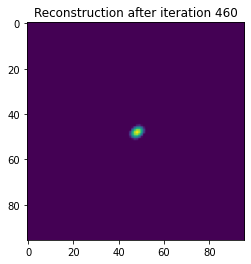

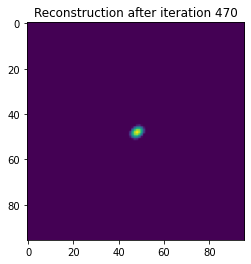

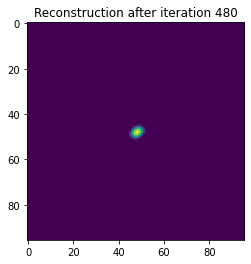

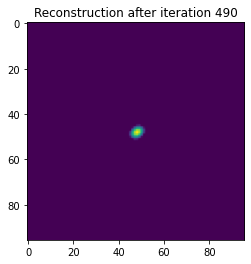

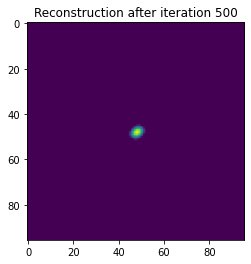

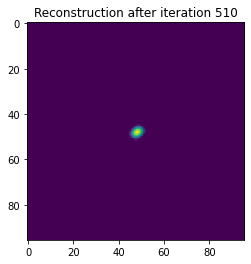

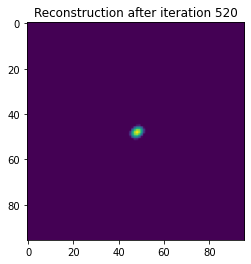

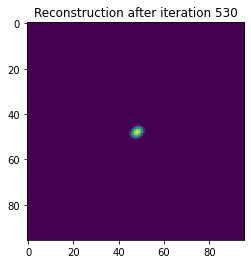

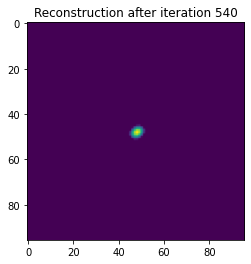

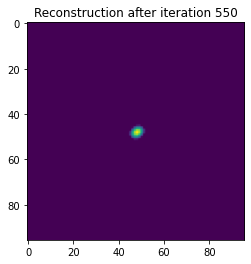

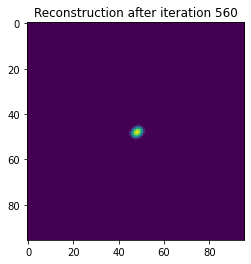

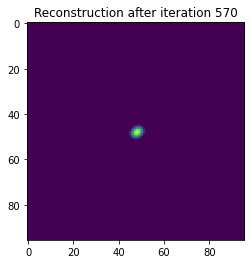

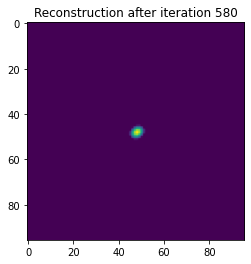

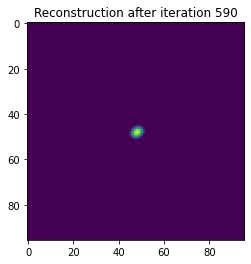

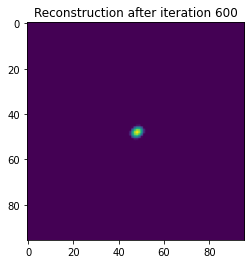

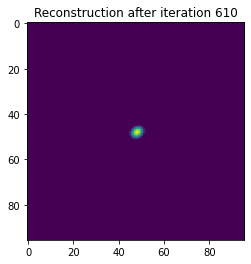

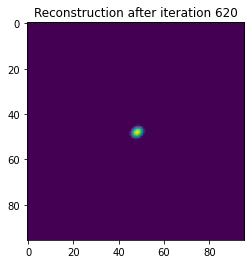

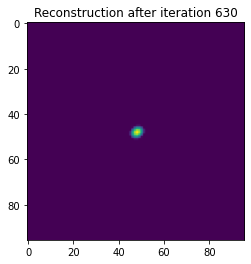

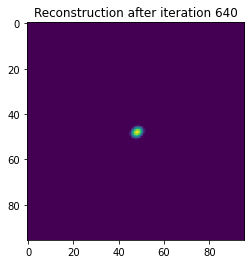

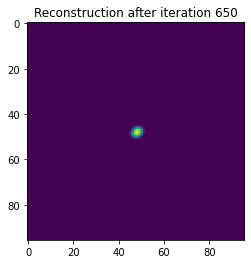

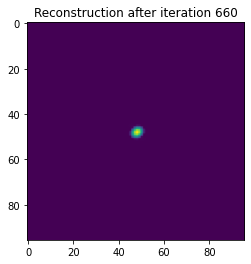

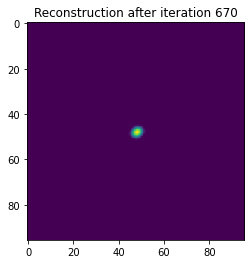

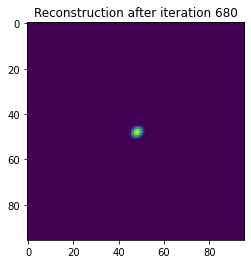

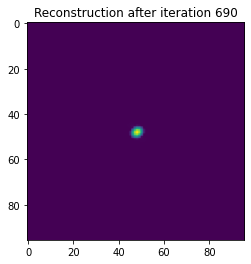

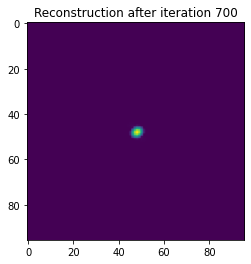

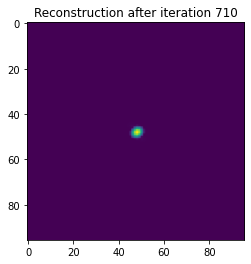

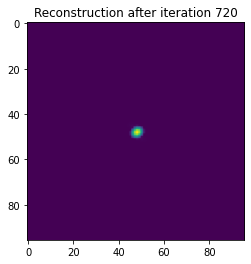

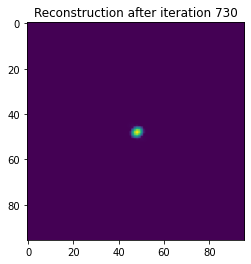

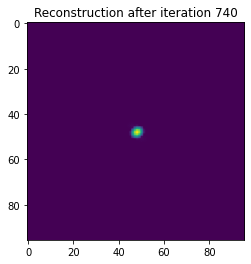

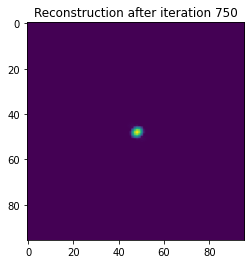

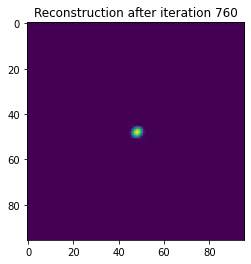

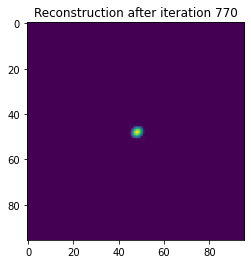

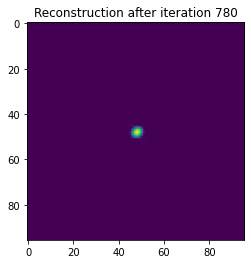

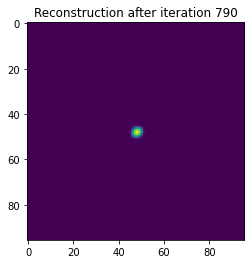

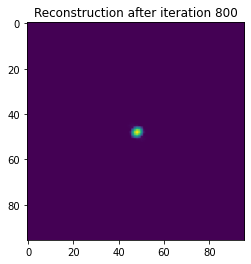

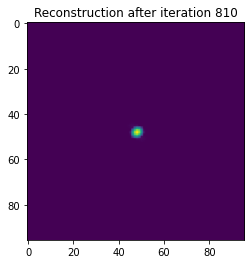

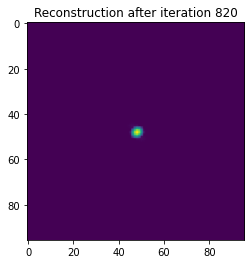

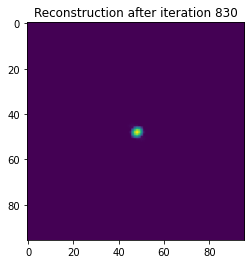

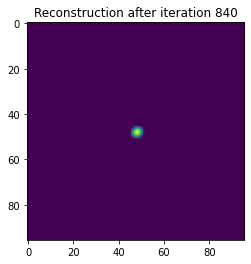

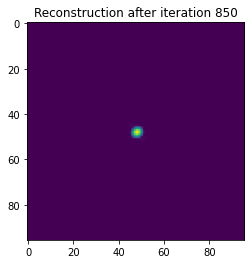

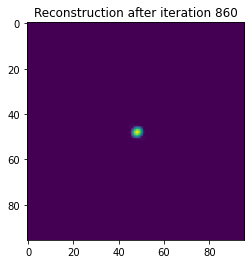

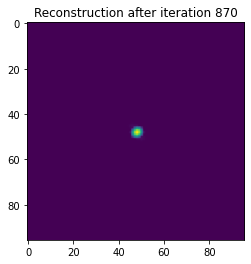

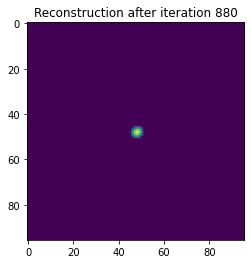

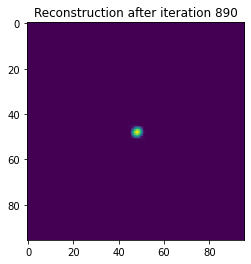

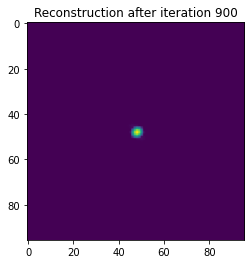

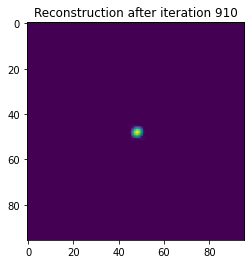

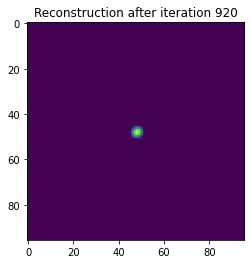

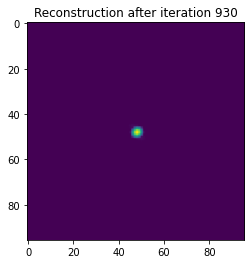

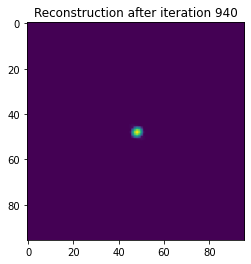

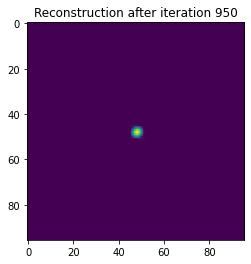

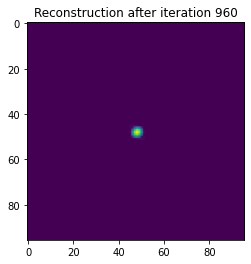

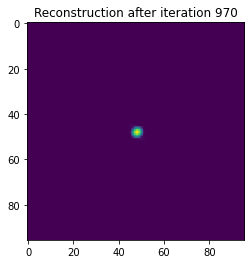

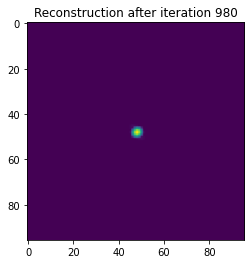

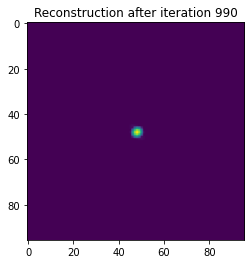

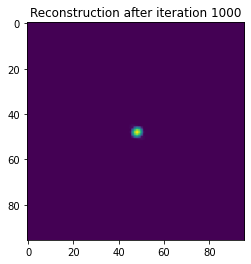

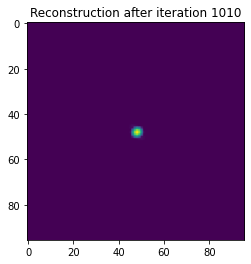

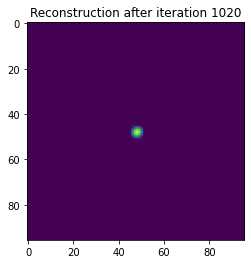

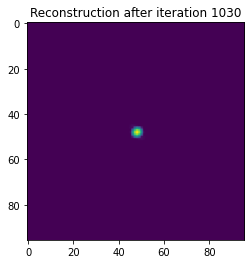

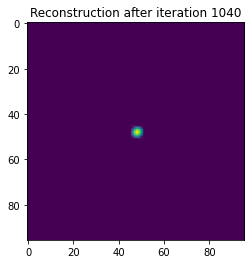

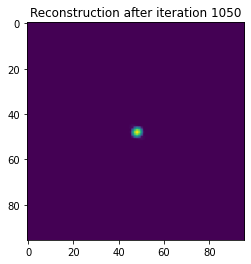

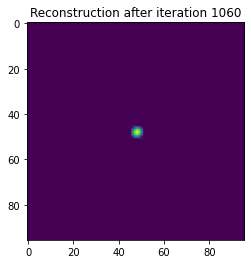

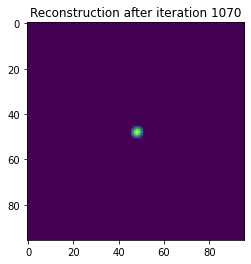

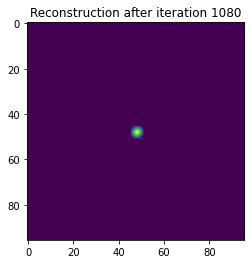

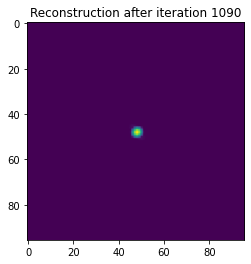

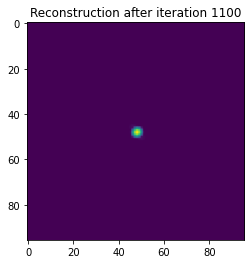

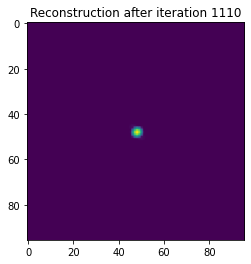

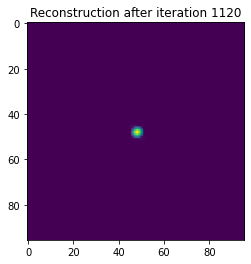

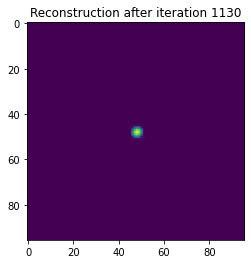

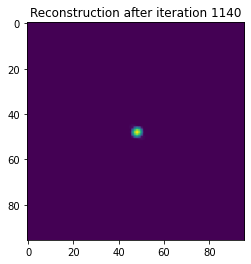

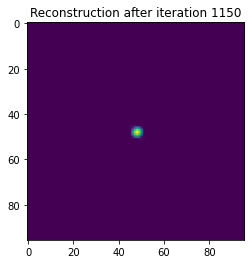

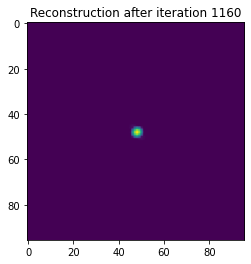

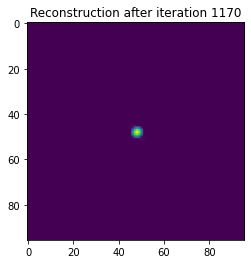

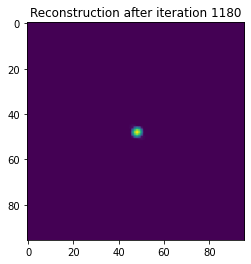

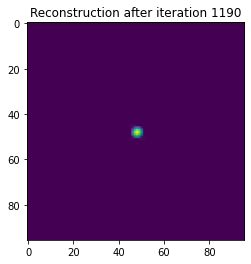

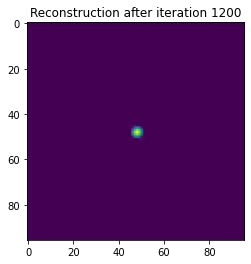

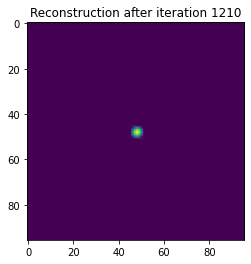

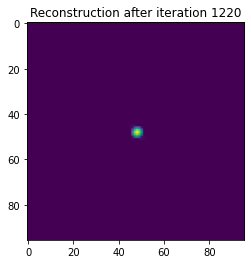

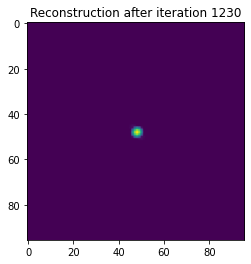

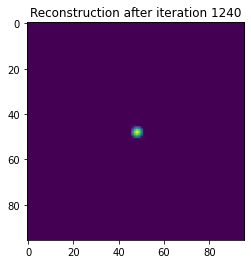

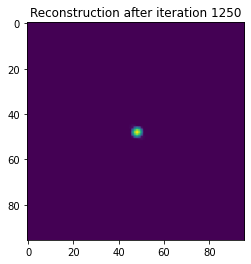

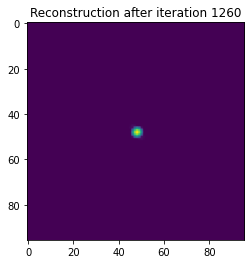

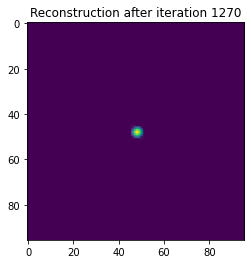

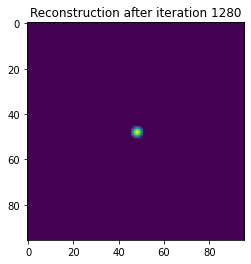

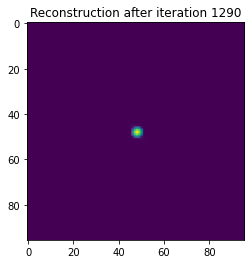

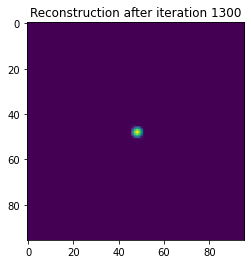

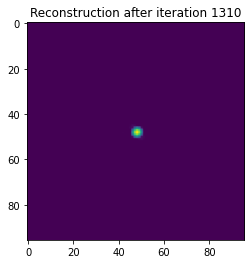

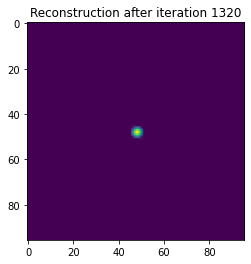

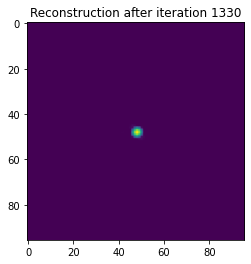

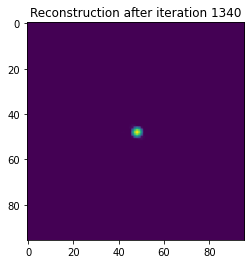

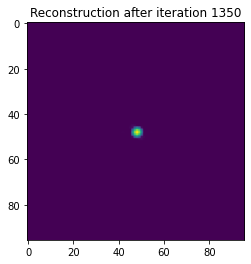

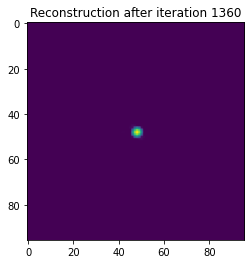

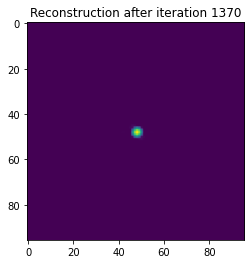

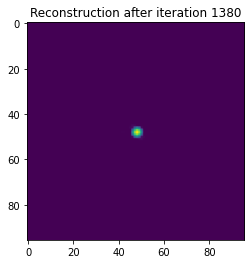

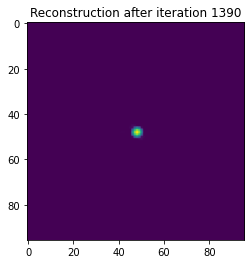

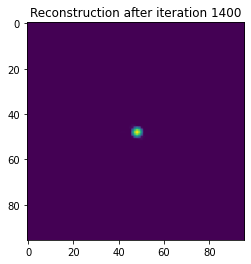

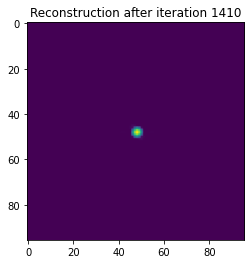

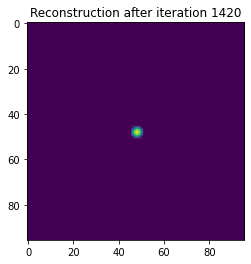

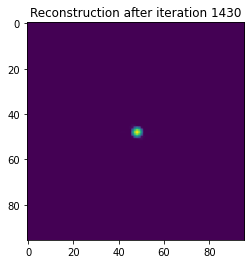

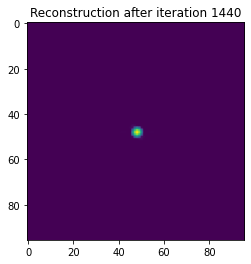

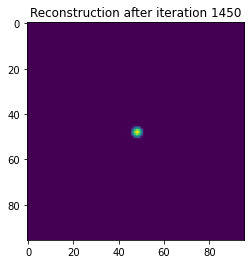

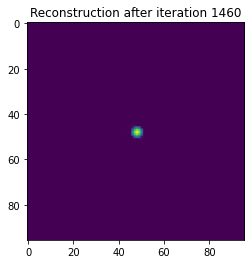

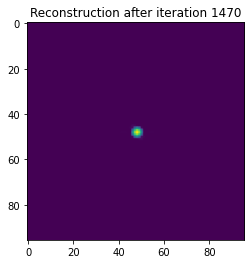

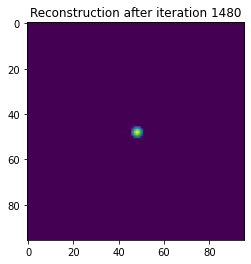

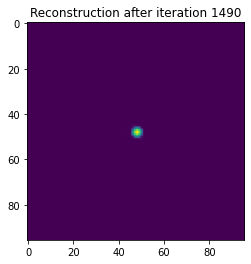

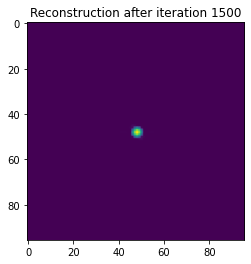

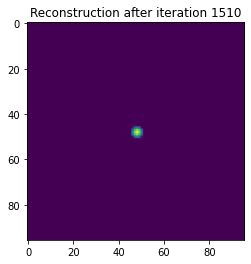

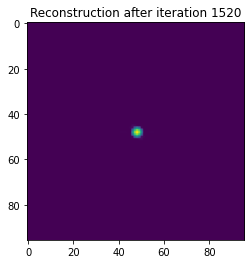

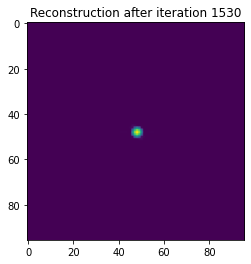

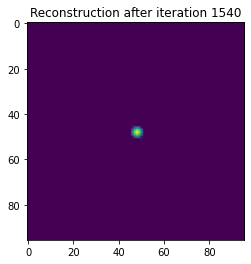

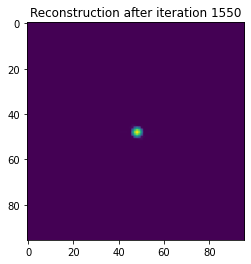

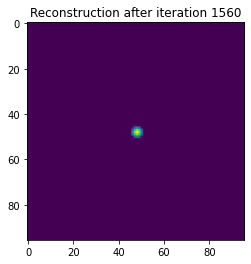

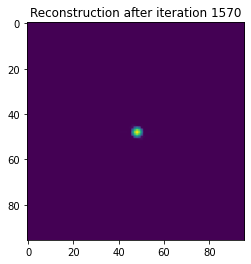

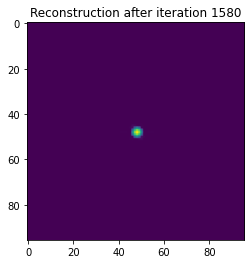

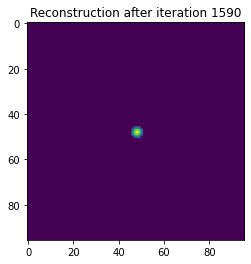

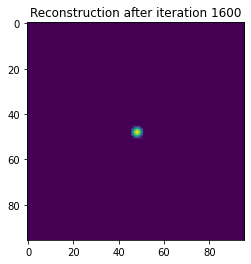

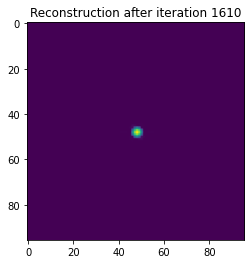

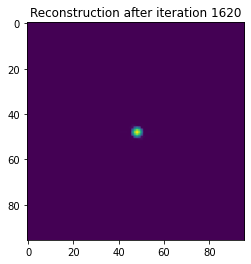

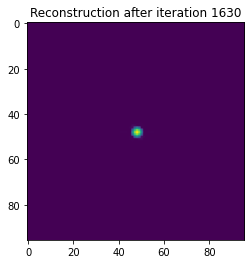

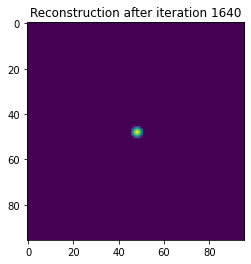

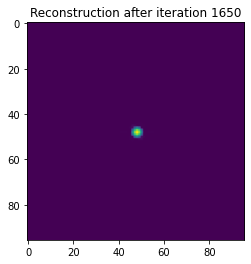

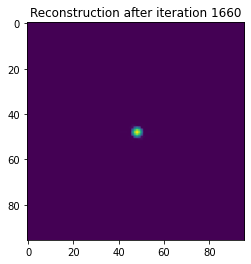

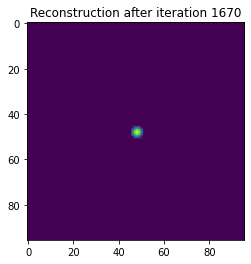

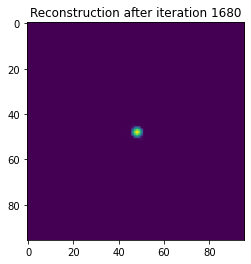

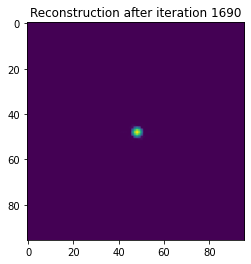

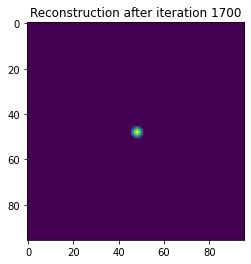

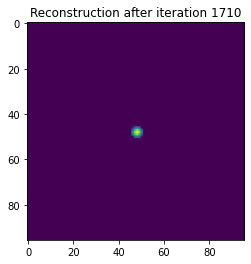

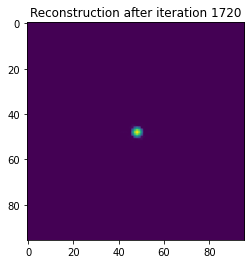

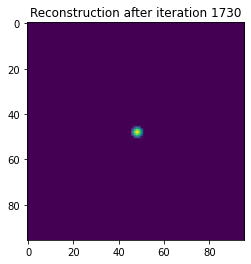

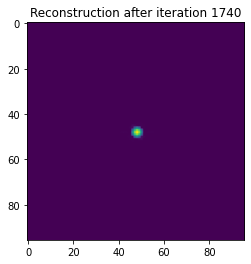

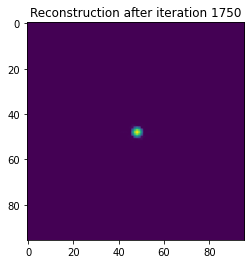

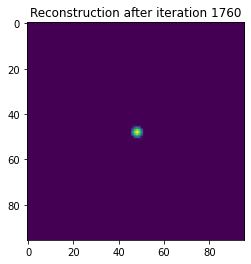

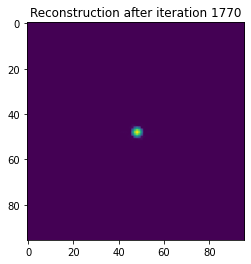

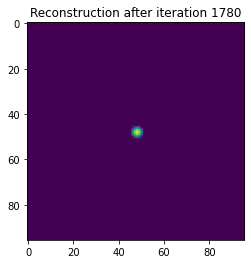

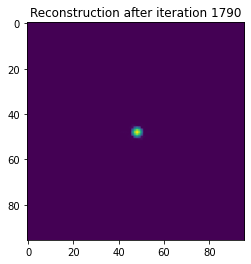

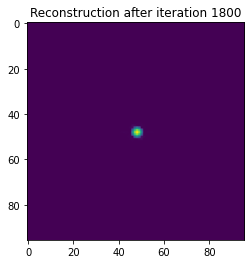

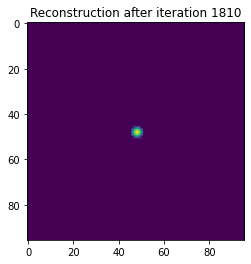

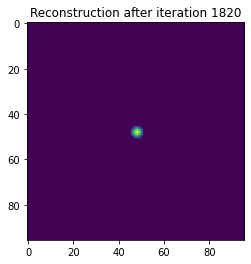

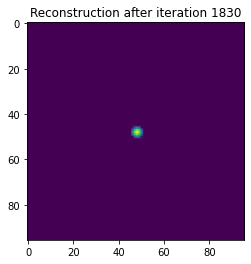

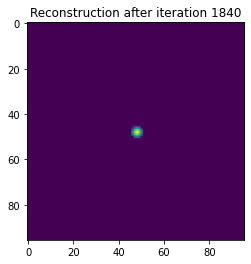

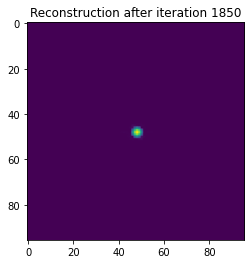

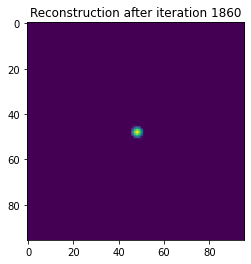

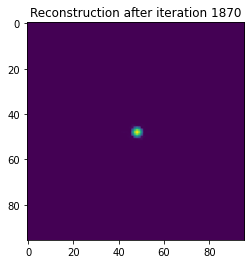

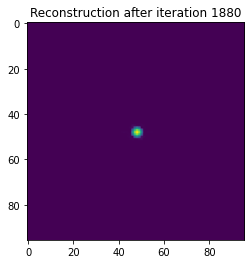

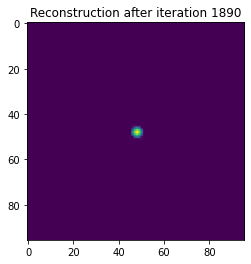

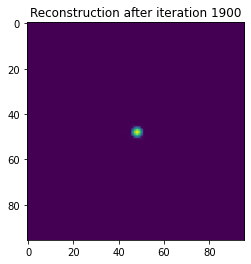

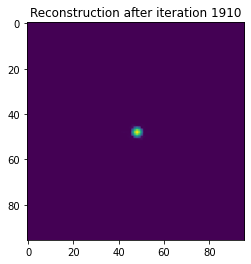

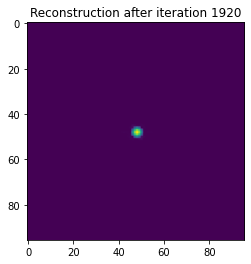

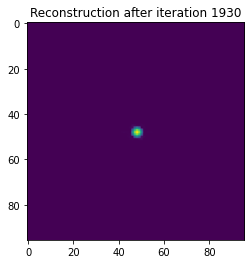

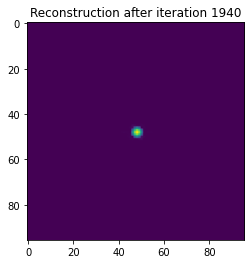

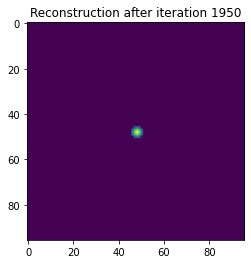

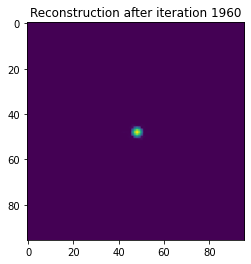

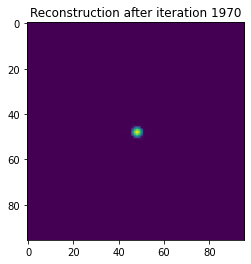

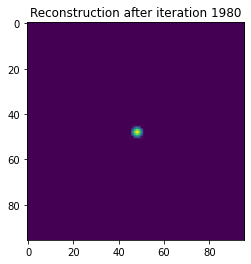

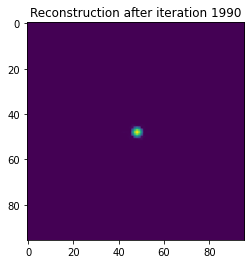

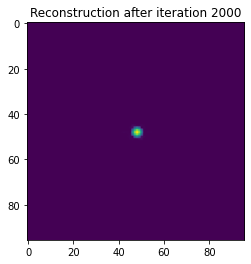

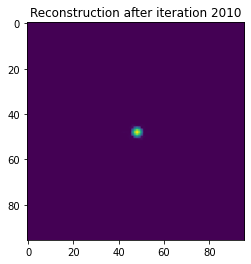

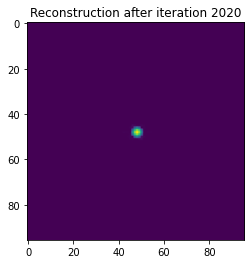

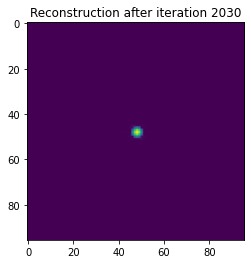

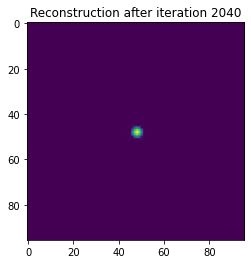

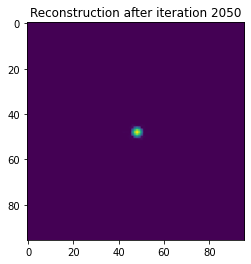

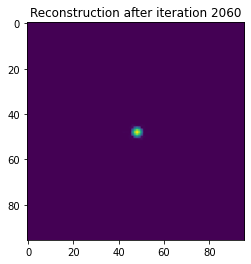

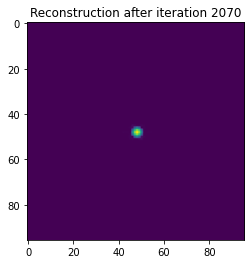

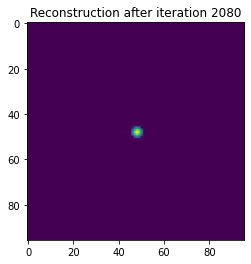

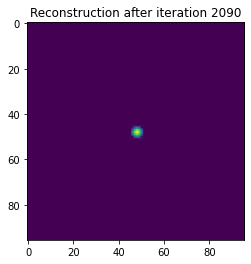

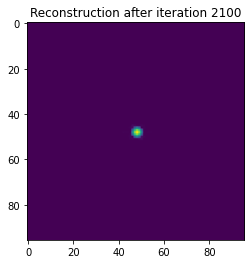

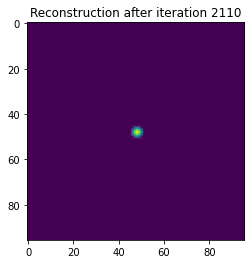

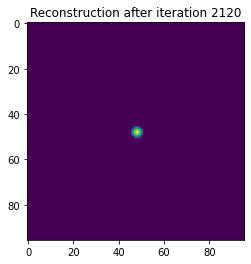

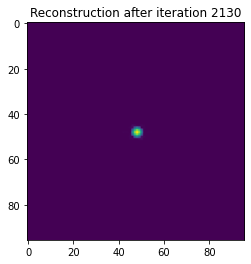

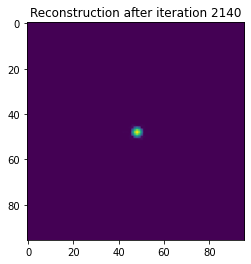

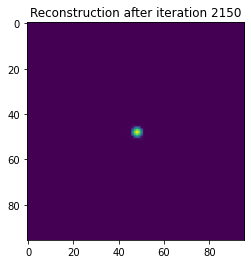

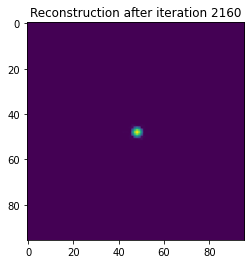

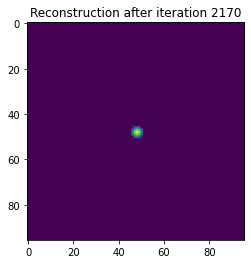

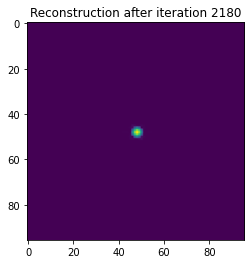

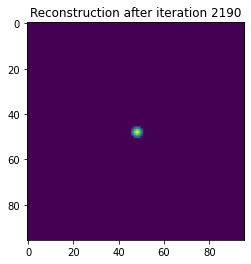

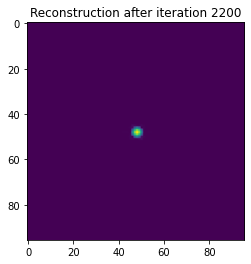

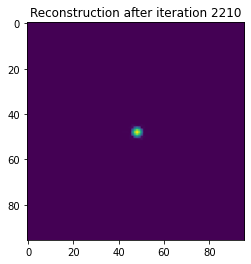

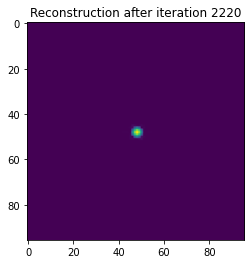

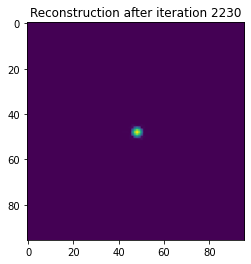

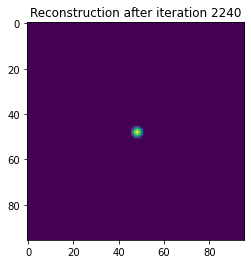

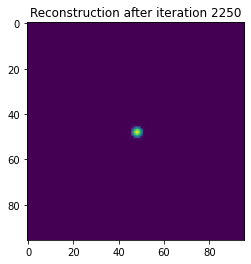

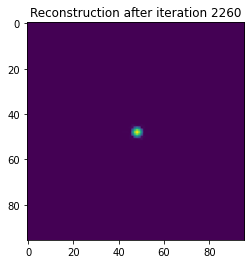

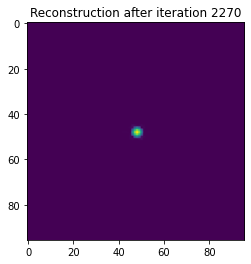

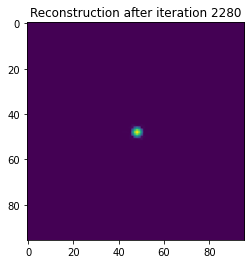

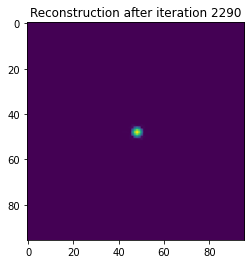

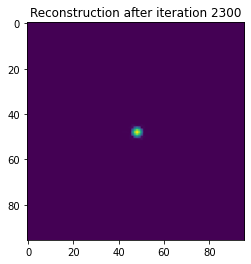

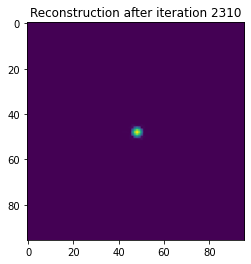

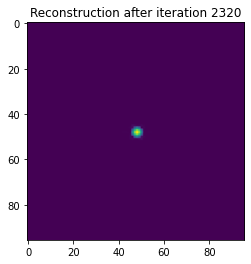

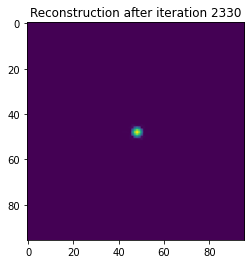

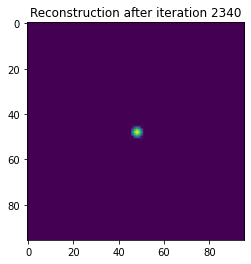

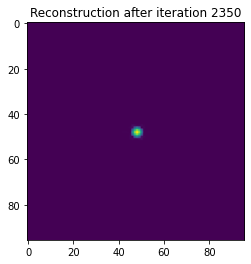

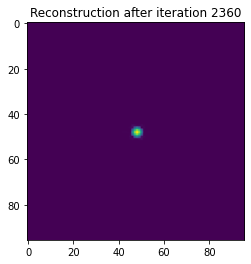

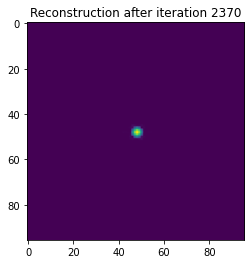

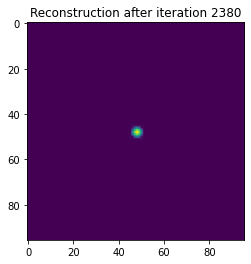

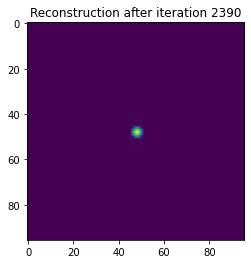

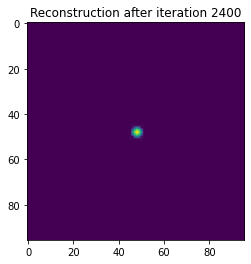

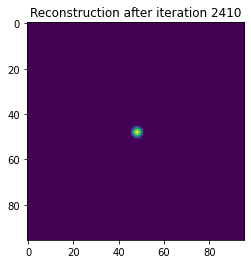

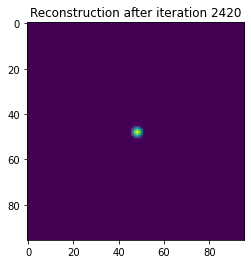

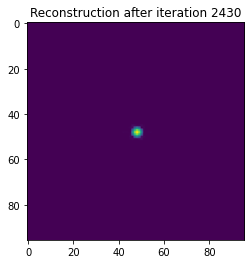

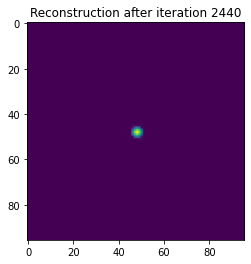

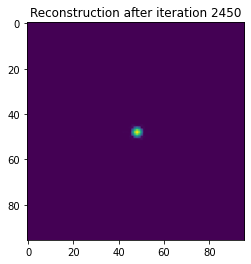

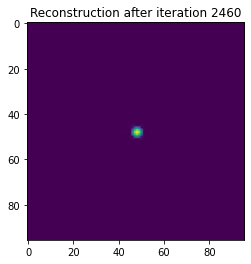

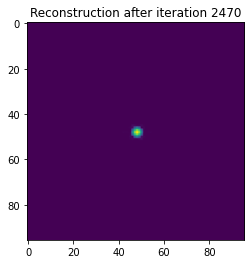

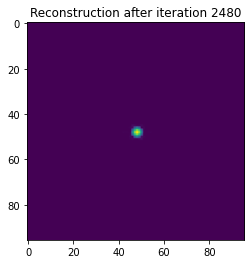

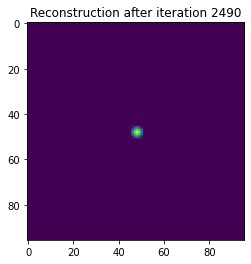

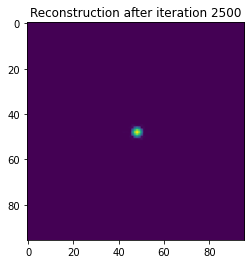

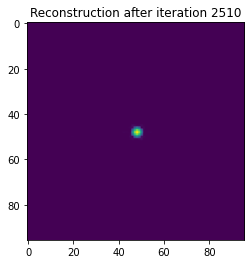

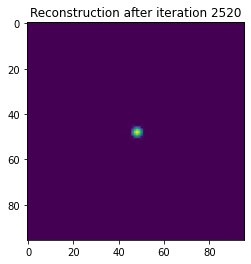

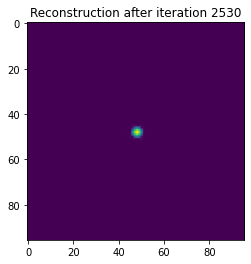

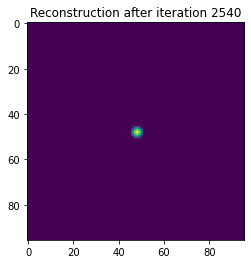

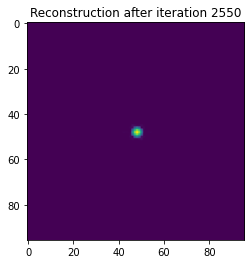

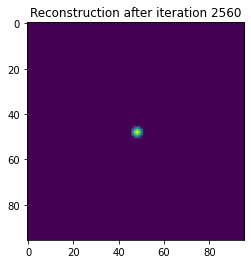

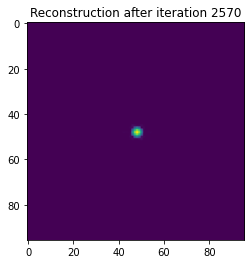

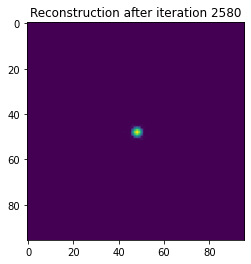

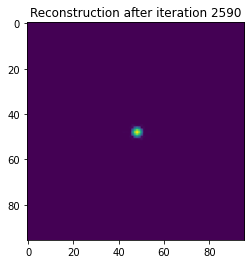

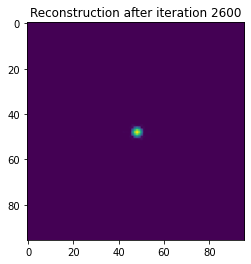

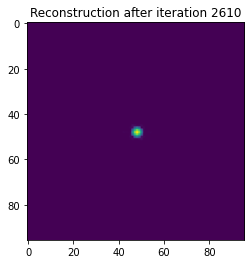

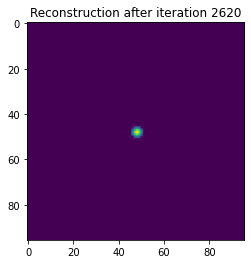

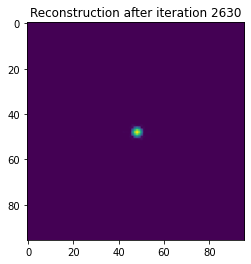

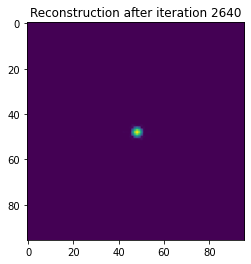

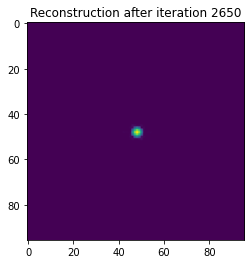

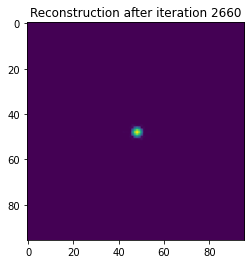

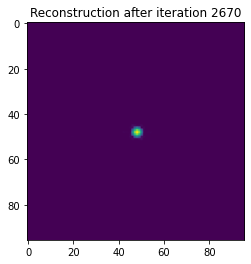

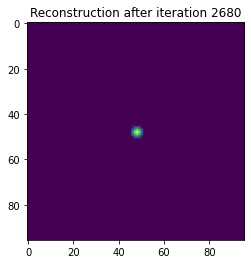

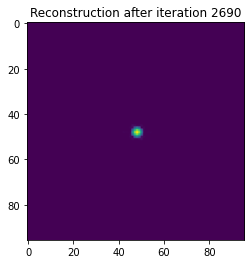

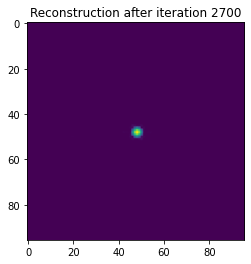

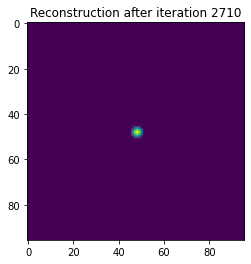

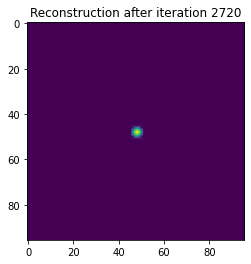

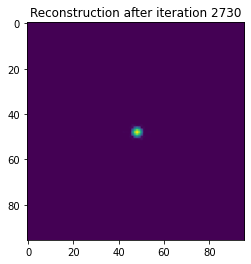

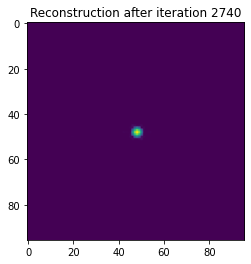

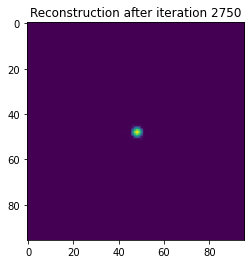

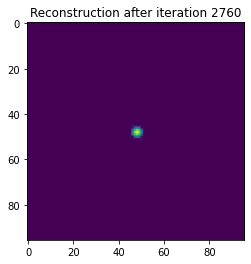

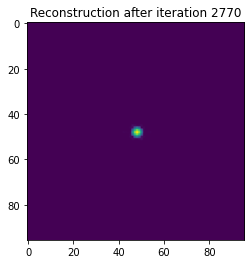

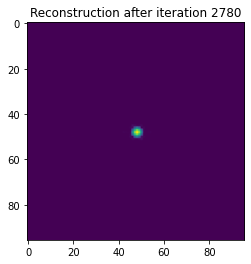

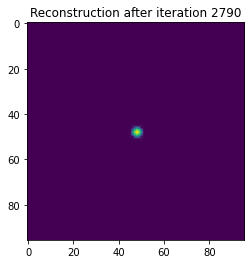

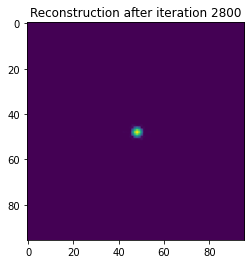

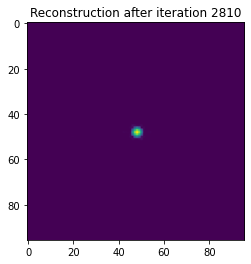

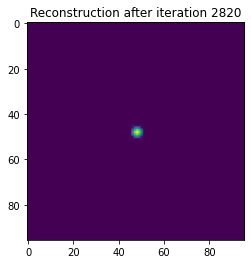

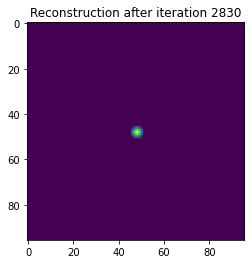

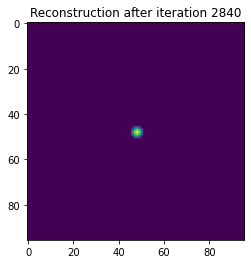

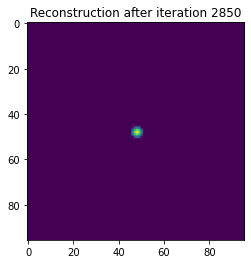

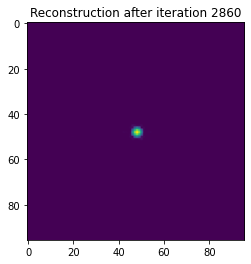

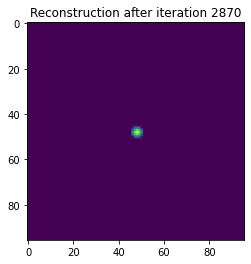

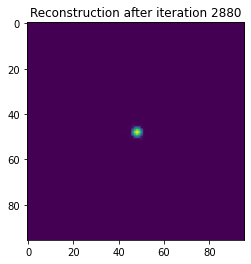

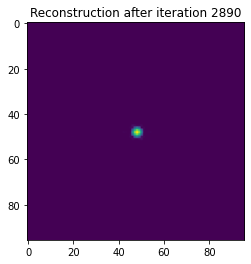

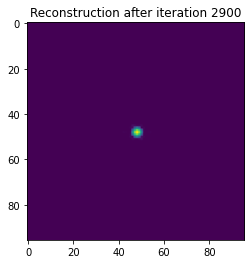

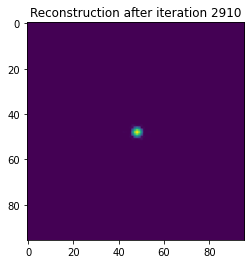

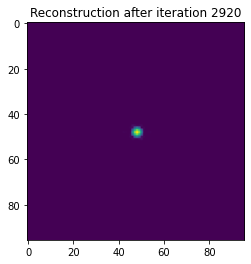

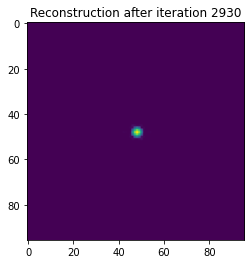

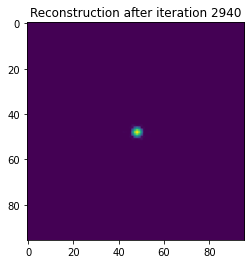

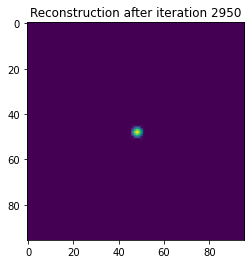

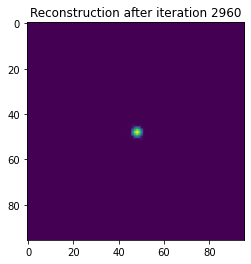

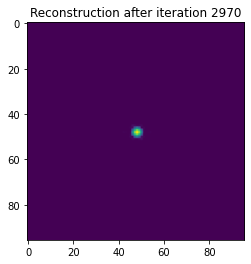

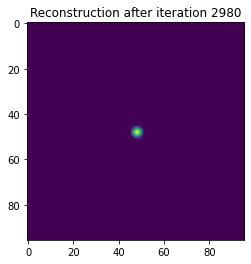

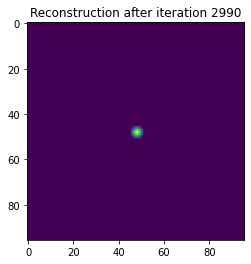

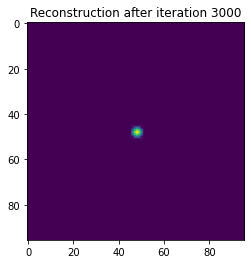

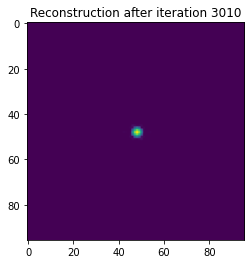

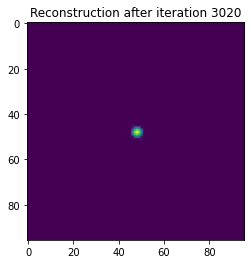

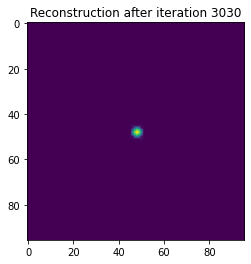

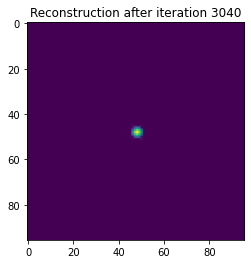

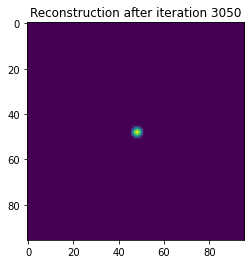

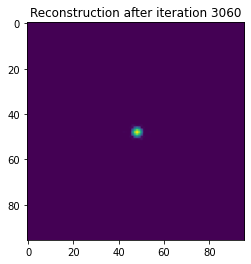

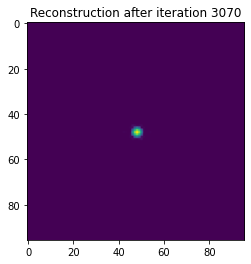

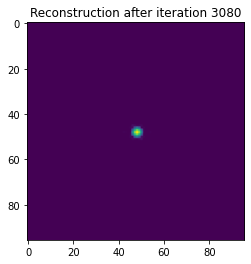

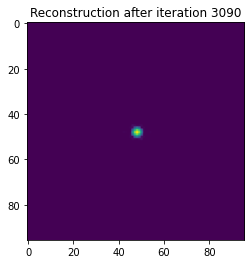

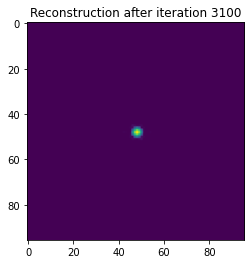

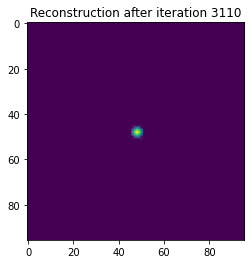

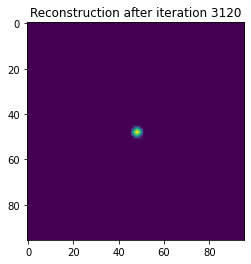

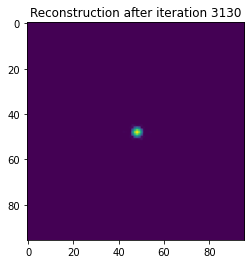

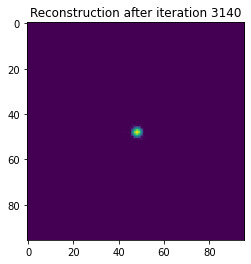

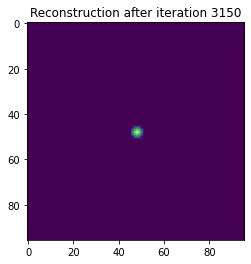

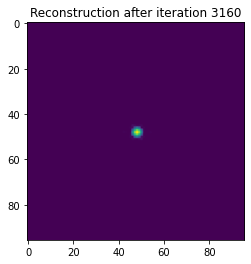

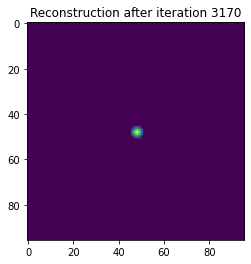

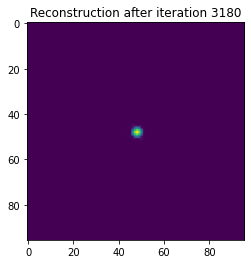

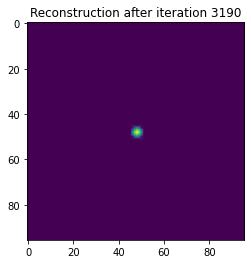

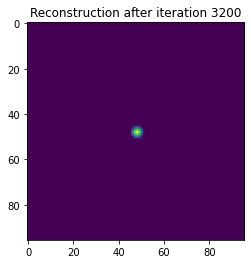

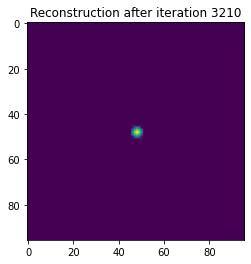

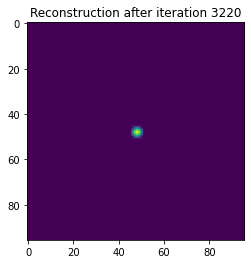

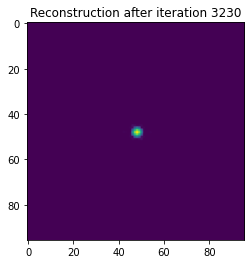

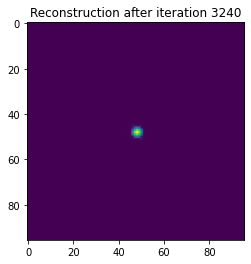

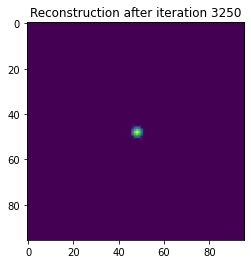

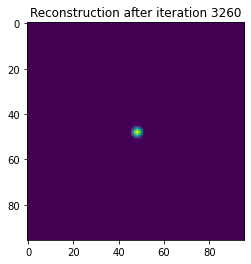

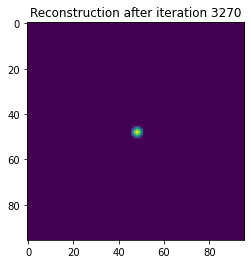

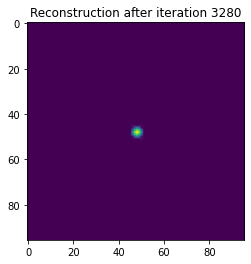

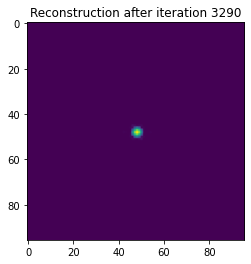

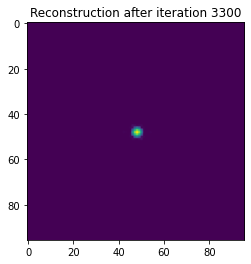

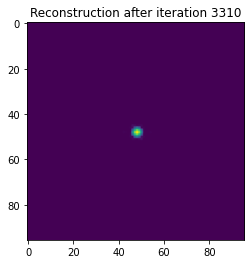

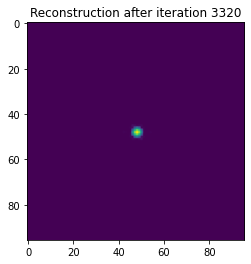

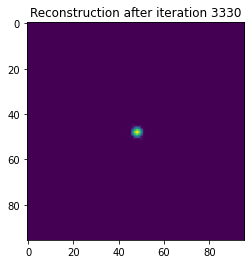

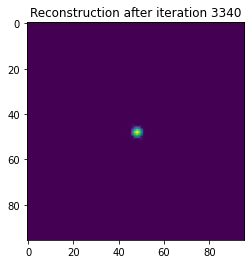

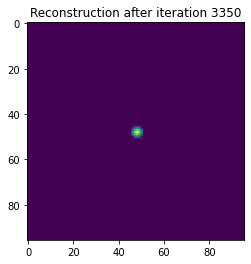

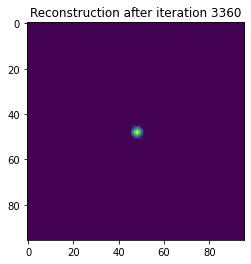

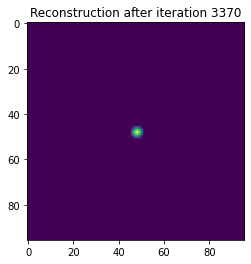

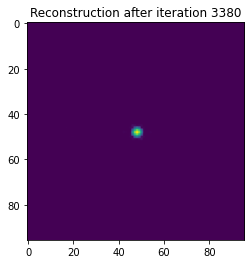

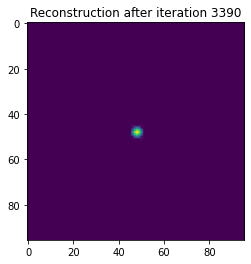

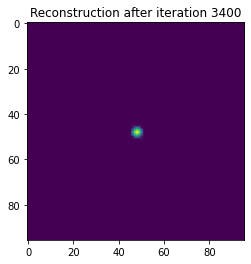

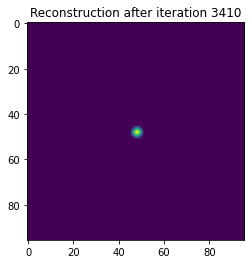

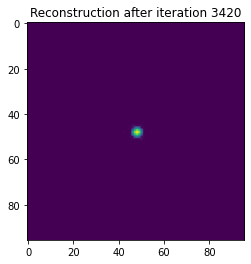

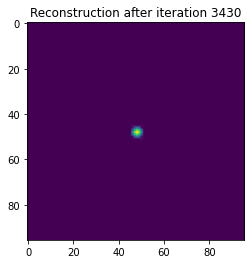

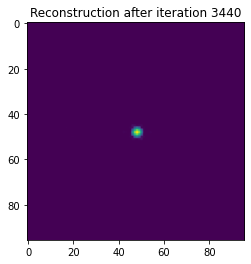

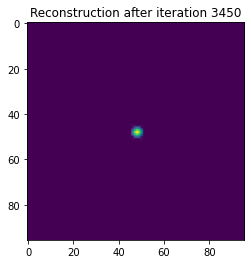

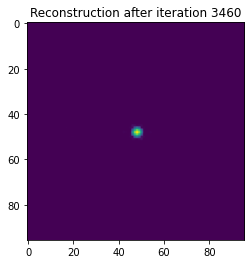

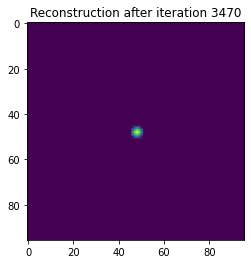

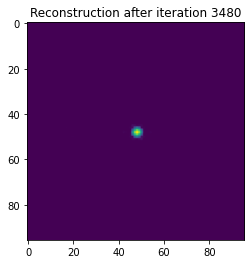

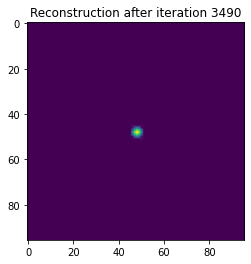

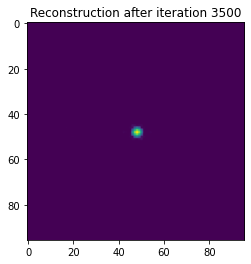

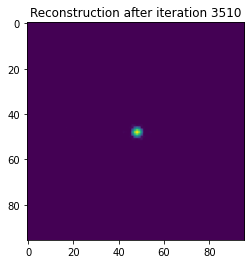

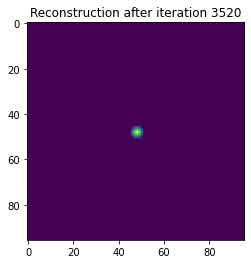

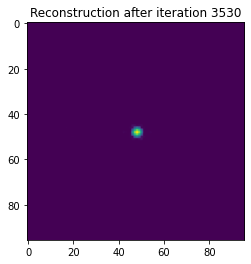

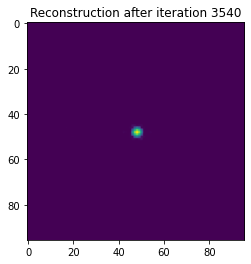

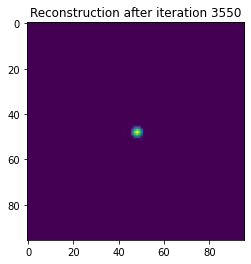

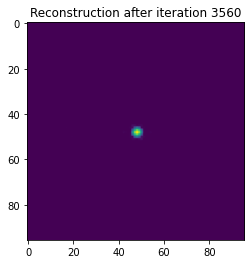

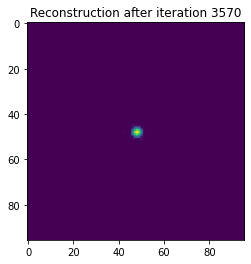

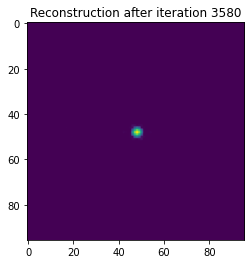

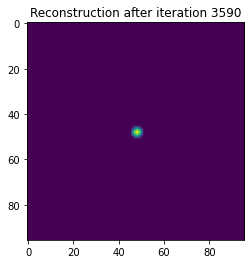

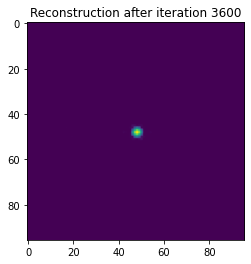

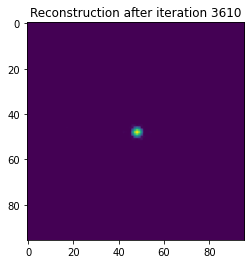

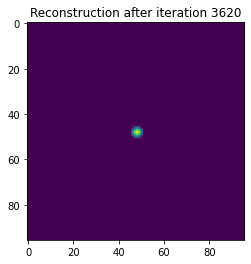

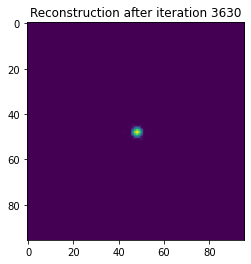

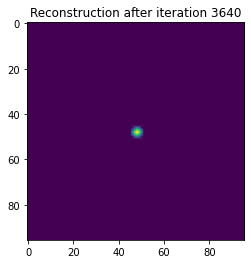

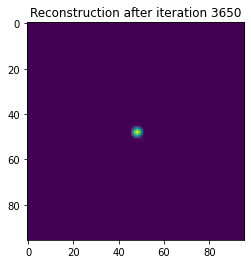

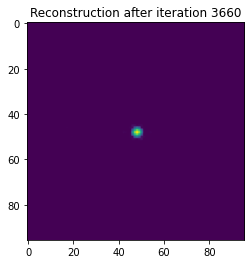

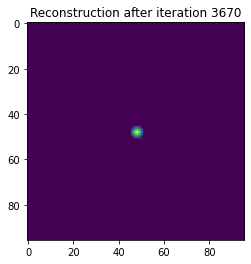

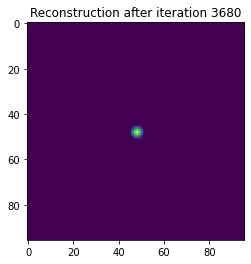

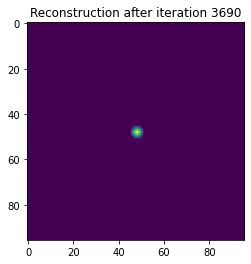

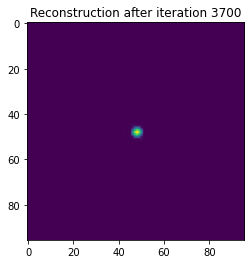

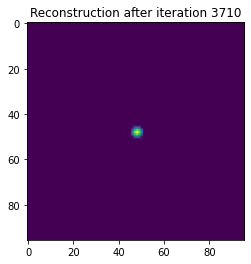

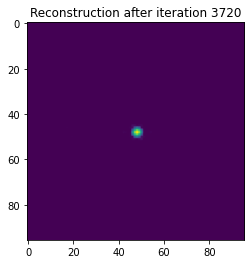

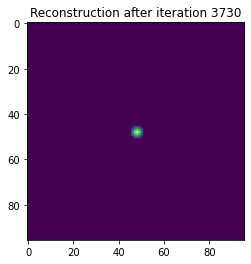

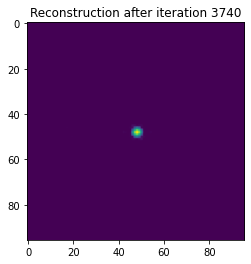

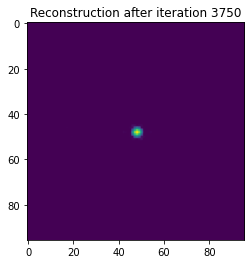

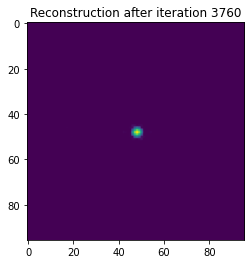

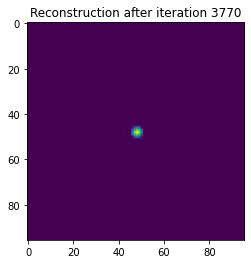

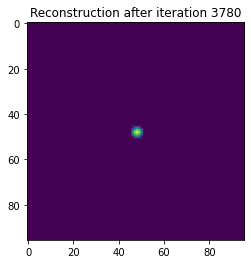

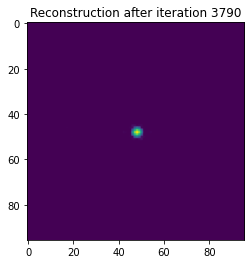

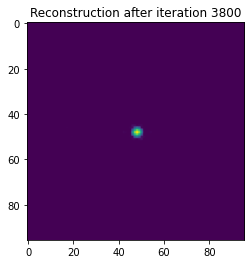

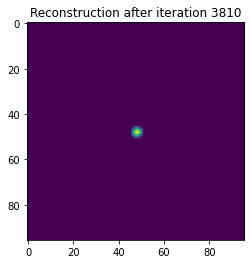

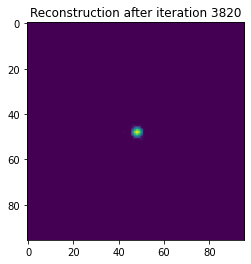

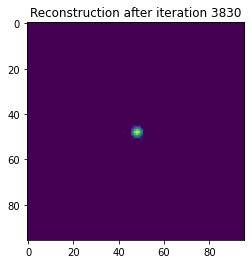

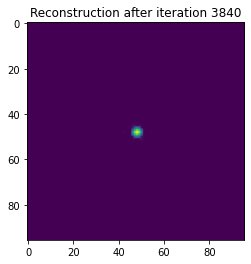

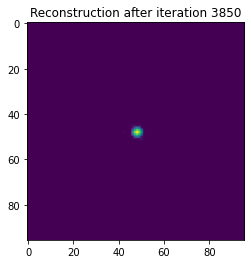

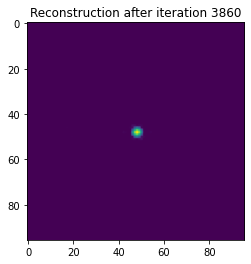

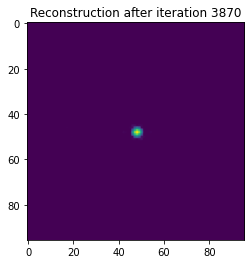

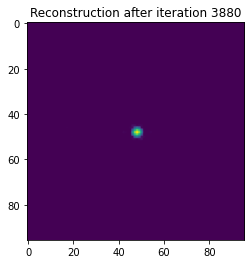

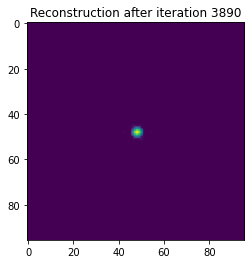

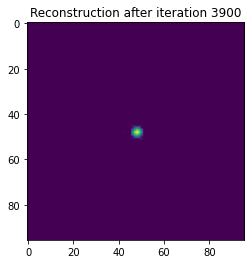

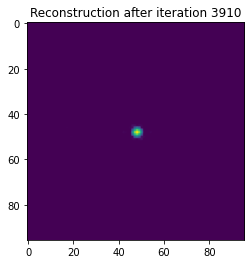

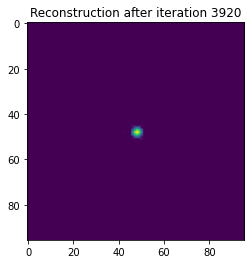

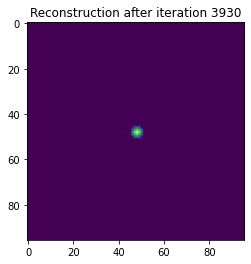

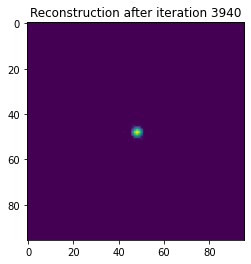

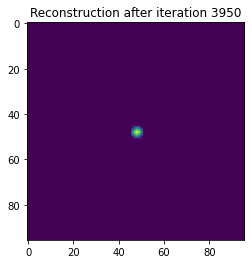

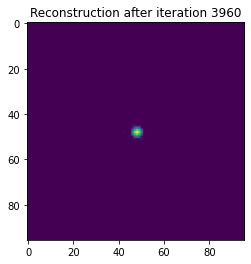

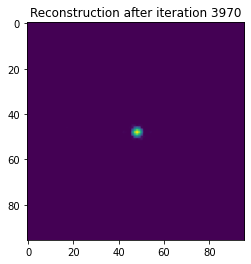

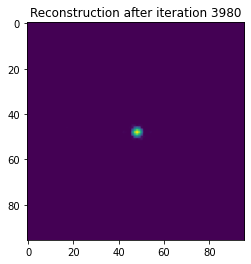

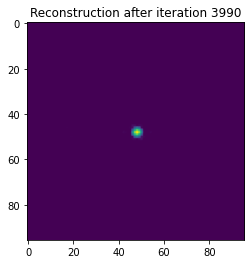

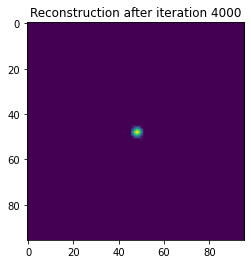

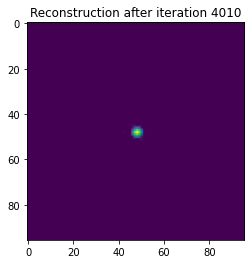

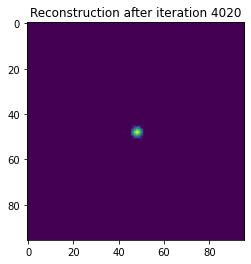

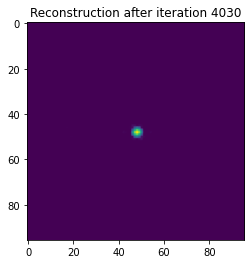

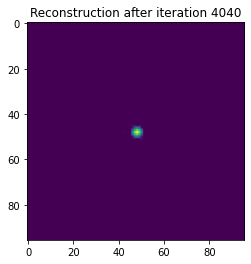

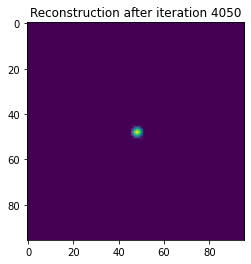

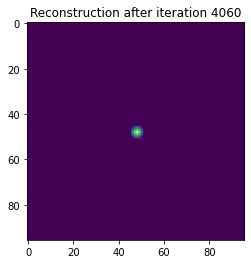

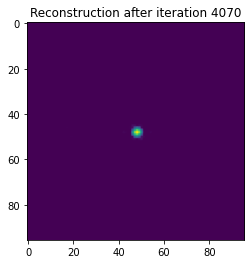

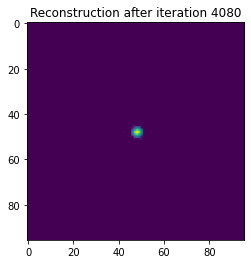

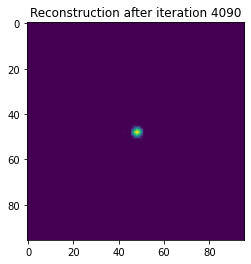

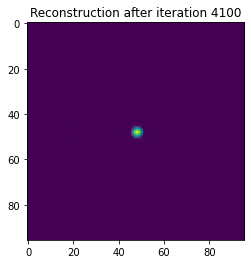

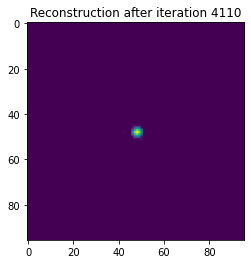

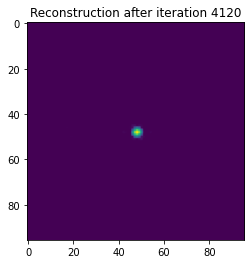

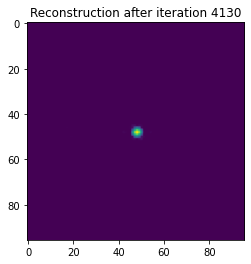

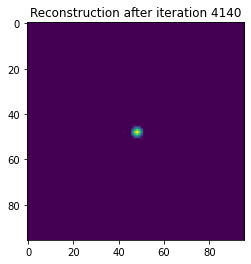

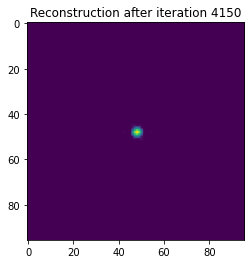

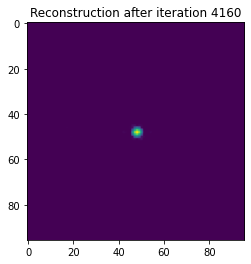

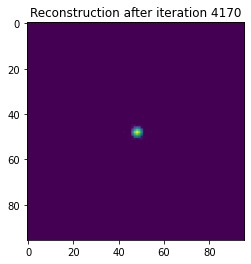

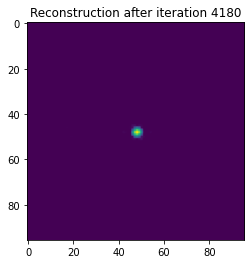

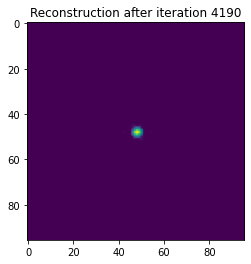

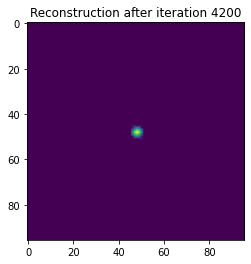

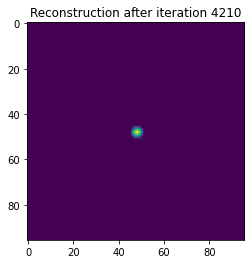

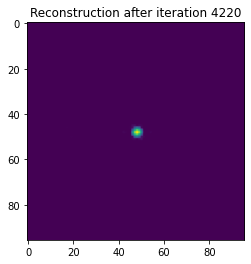

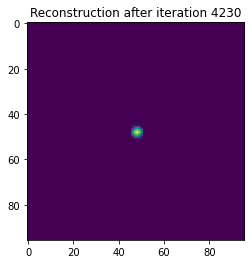

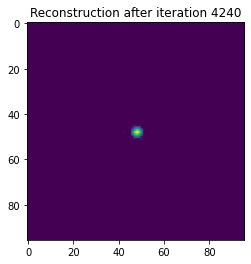

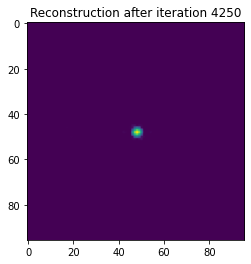

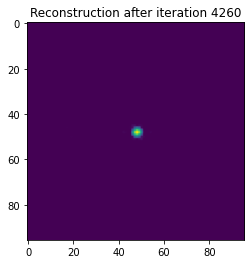

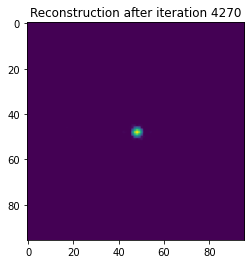

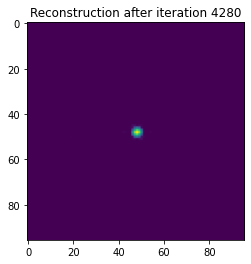

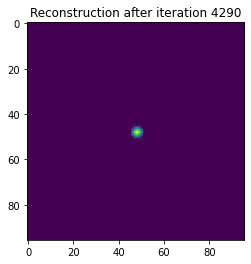

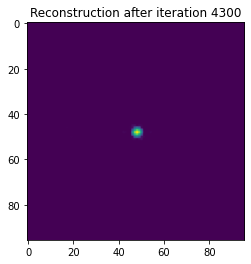

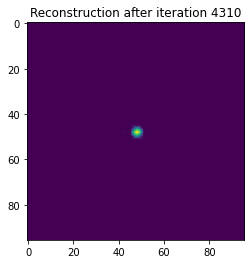

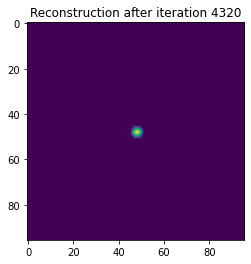

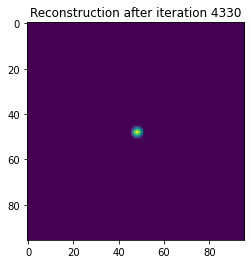

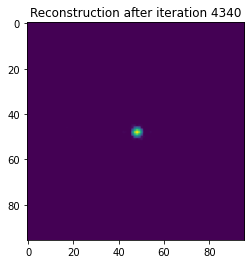

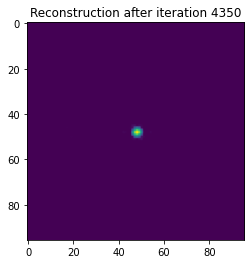

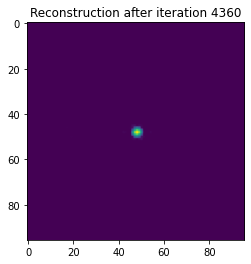

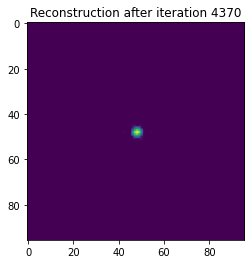

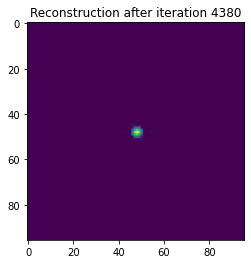

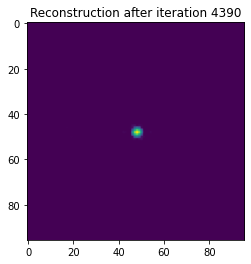

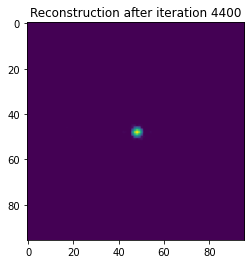

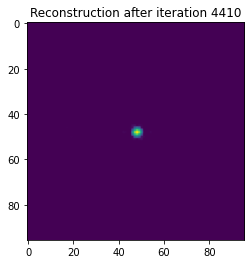

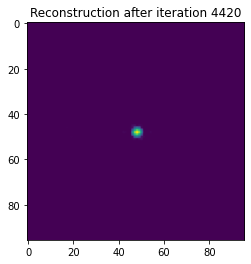

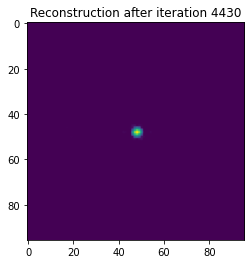

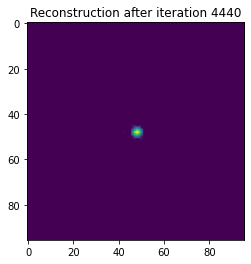

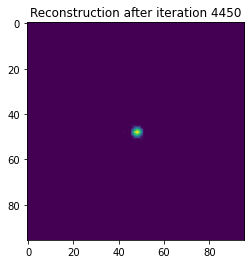

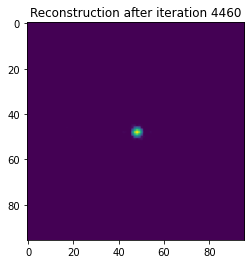

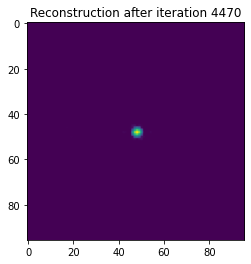

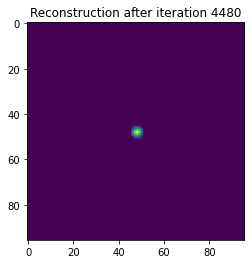

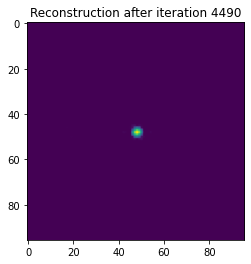

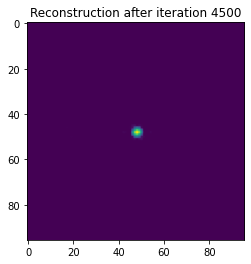

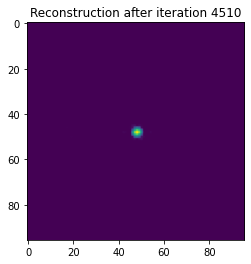

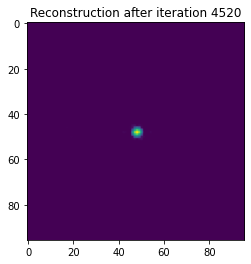

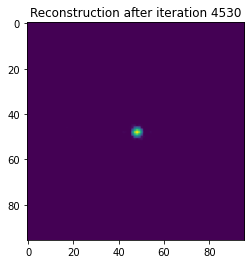

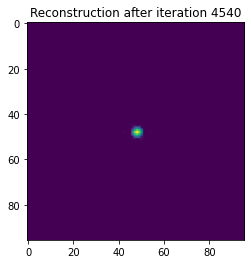

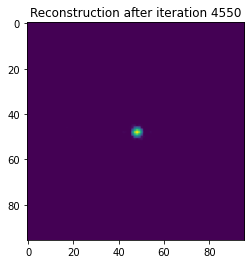

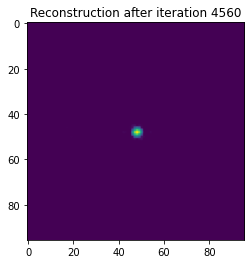

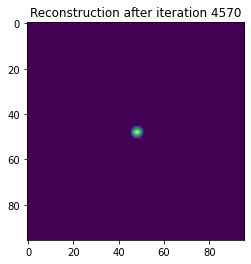

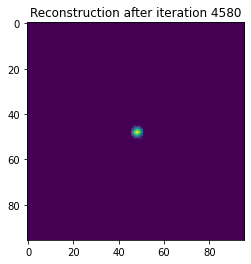

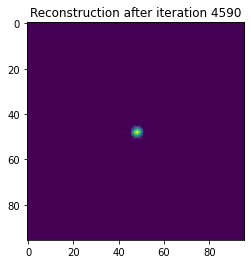

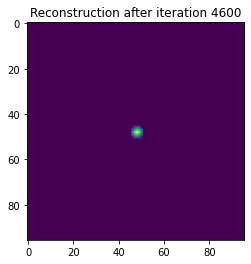

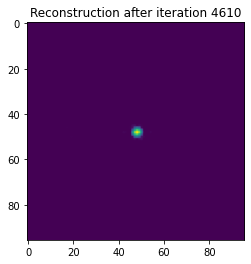

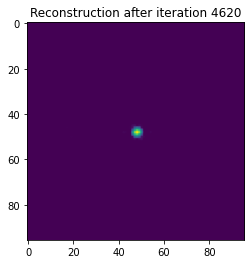

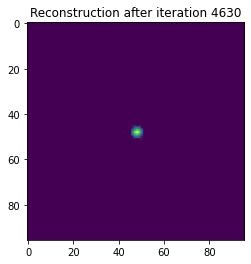

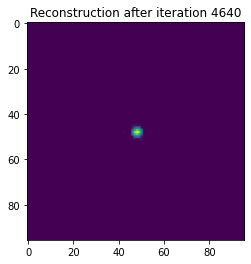

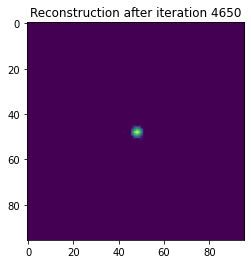

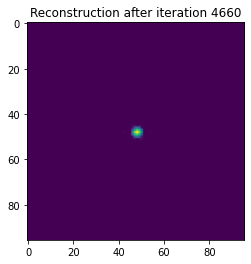

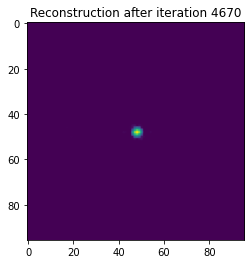

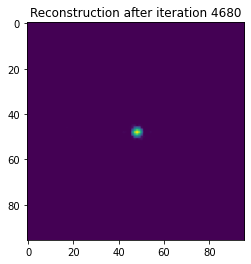

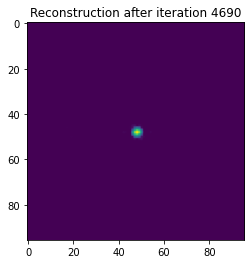

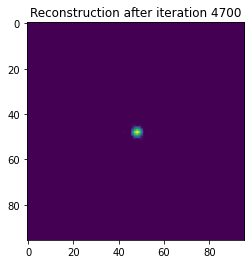

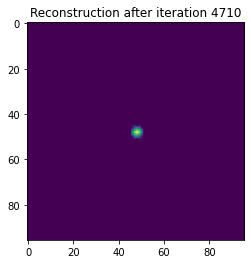

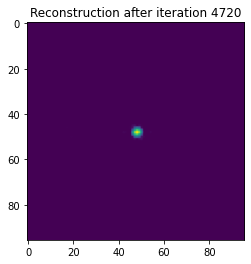

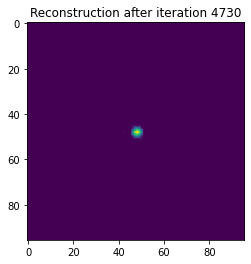

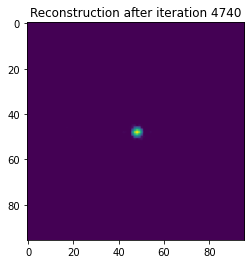

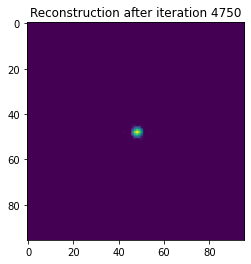

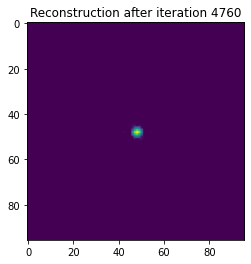

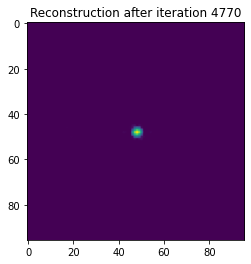

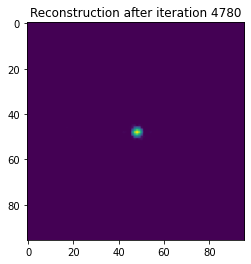

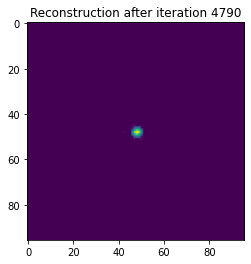

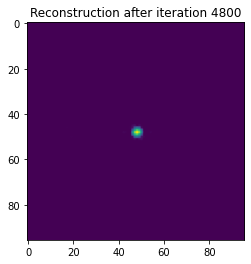

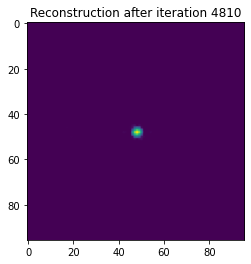

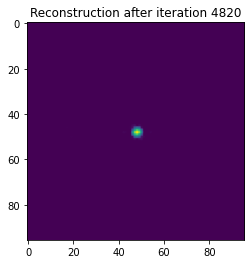

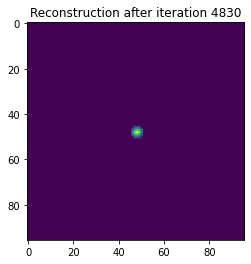

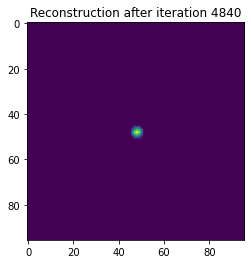

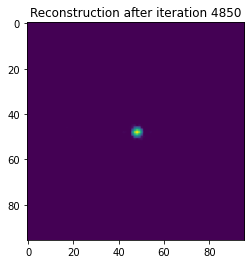

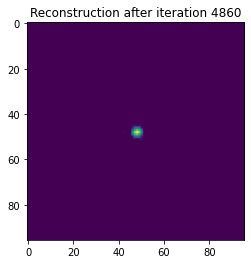

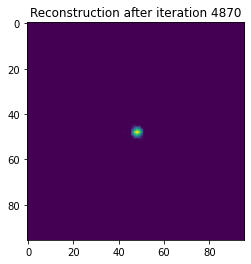

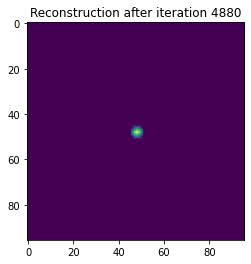

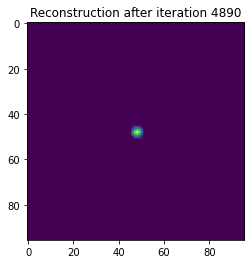

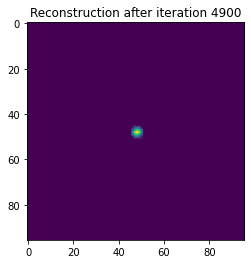

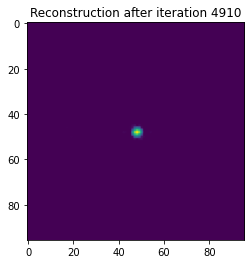

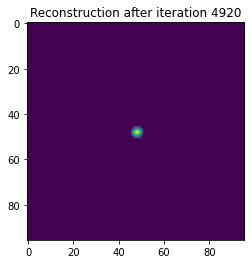

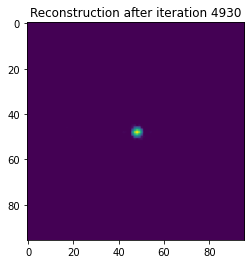

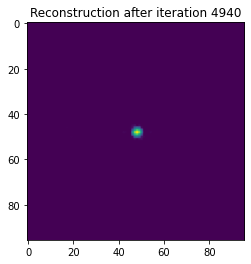

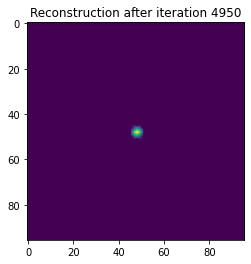

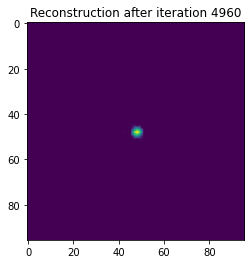

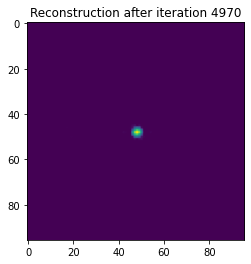

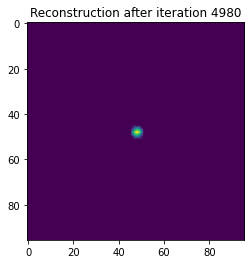

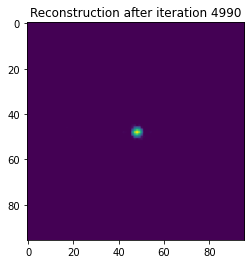

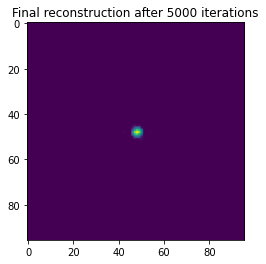

In [20]:
final_im, mse_arr = grad_descent(psf_img1, final_gal)
plt.imshow(final_im)
plt.title('Final reconstruction after {} iterations'.format(iters))
plt.show()

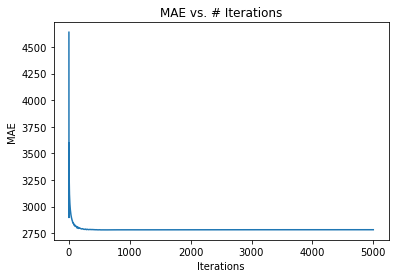

Minimum MAE at 570 iterations


In [21]:
plt.plot(np.arange(1,iters+1), mse_arr)
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('MAE vs. # Iterations')
plt.show()

min_iter = np.where(mse_arr == np.min(mse_arr[2:]))[0][0]
print('Minimum MAE at {} iterations'.format(min_iter))